# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.special import softmax
from collections import defaultdict
import math
from tqdm.notebook import tqdm
import concurrent.futures
import json
import time

In [ ]:
np.random.seed(123)

## Environment description

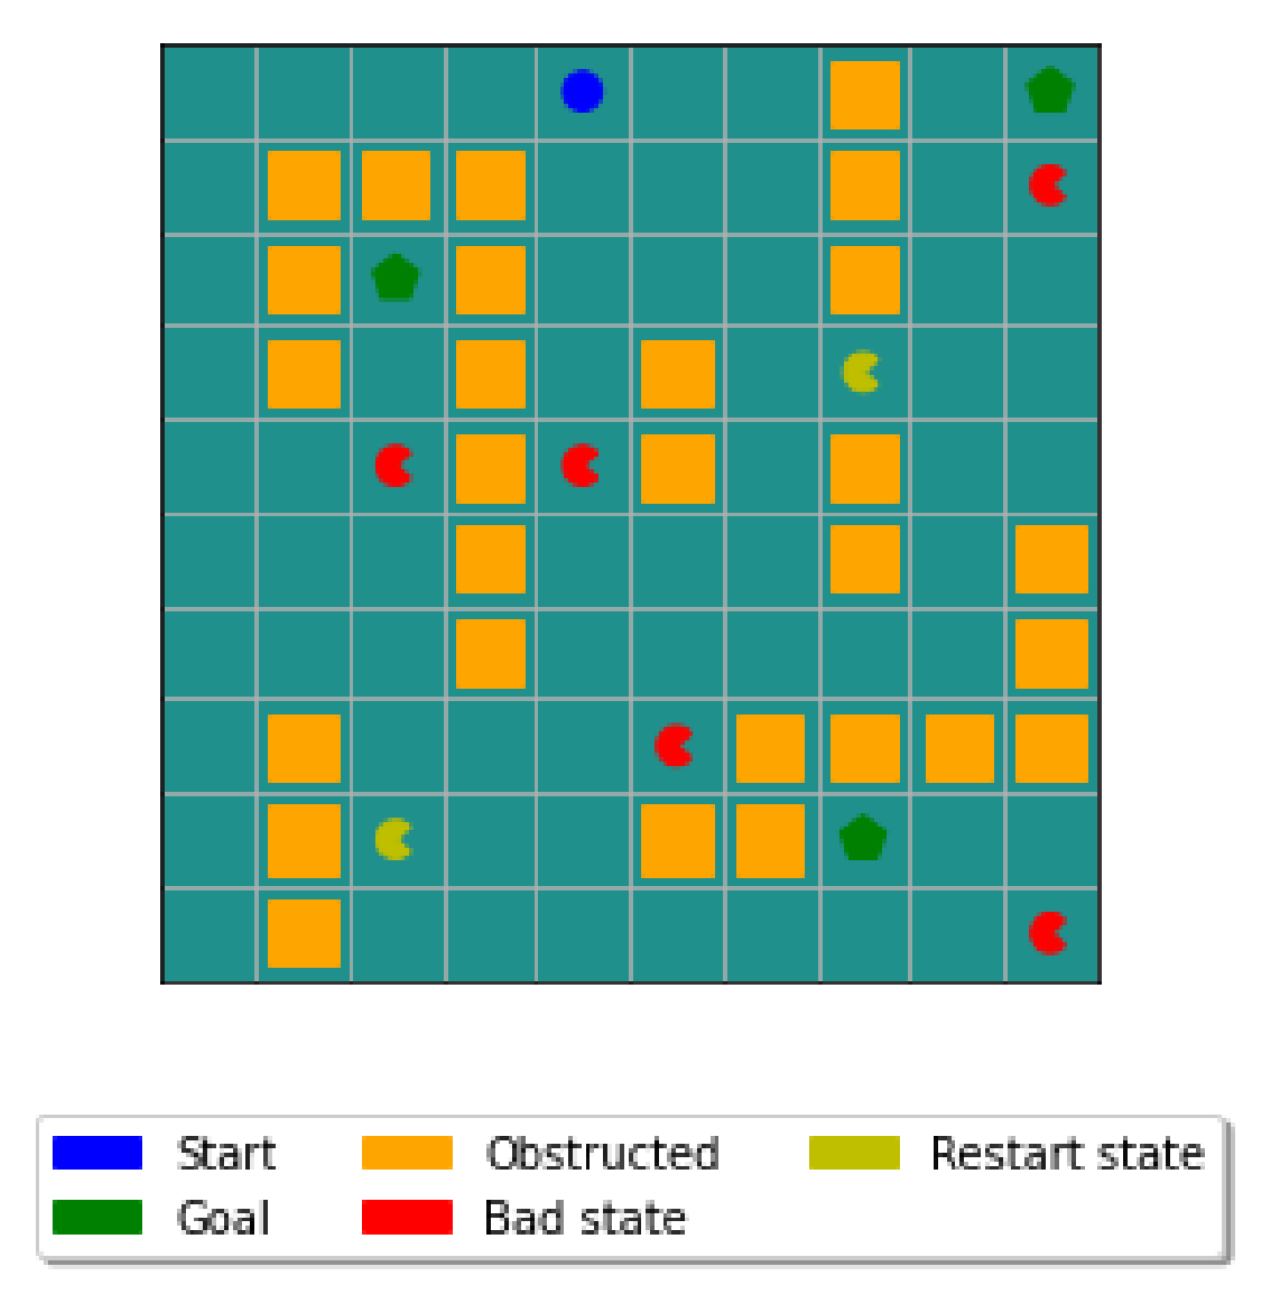

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

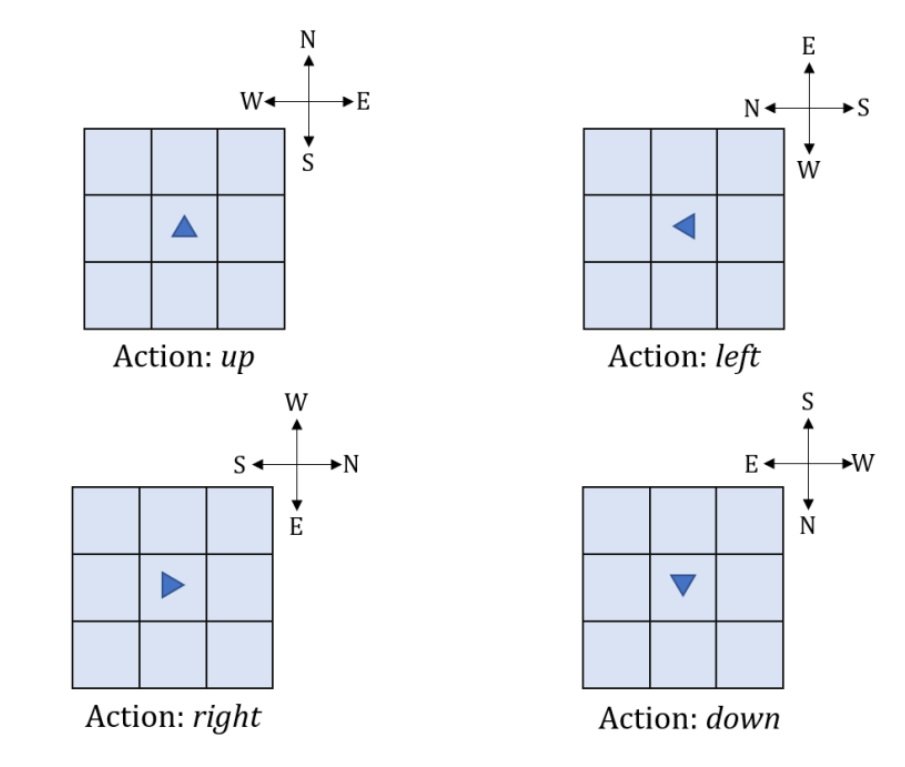

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

In [ ]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Converts row_column format to state number
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]


# Converts state number to row_column format
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [ ]:
# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

## Visualize the grid world

In [ ]:
# visualize the grid world configuration
env.visualize_gridworld()

## List environment variables

In [ ]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

# SARSA

In [4]:
class SARSA:
    def __init__(self, env, num_agents=50, alpha=0.1, gamma=0.99, epsilon=None, temperature=None, strategy='greedy'):
        self.env = env
        self.num_agents = num_agents
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.temperature = temperature
        self.strategy=strategy

    def epsilon_greedy(self, state, Q):
        if np.random.rand() < self.epsilon:
            return np.random.choice(np.arange(self.env.num_actions))
        else:
            return np.argmax(Q[state])

    def softmax_policy(self, state, Q):
        action_probs = softmax(Q[state] / self.temperature)
        return np.random.choice(np.arange(self.env.num_actions), p=action_probs)

    def train_agents(self, num_episodes=1000, max_steps=100):
        hyper_comp_reward = 0
        
        agent_reward_val = -np.inf
        
        reward_best = np.zeros([num_episodes])
        steps_to_goal_best = np.zeros([num_episodes])
        state_visits_best = np.zeros([self.env.num_states], dtype=int)
        Q_values_best = []

        if self.strategy == 'greedy':
            self.exploration = self.epsilon_greedy
        else:
            self.exploration = self.softmax_policy

        for agent in range(self.num_agents):
            
            rewards = np.zeros([num_episodes], dtype=int)
            steps_to_goal = np.zeros([num_episodes], dtype=int)
            state_visits = np.zeros([self.env.num_states], dtype=int)
            Q_values = np.zeros([self.env.num_states, self.env.num_actions])
            
            for ep in range(num_episodes):
                state = self.env.reset()
                action = self.exploration(state, Q_values)
                episode_steps = 0


                while episode_steps < max_steps:
                    next_state, reward = self.env.step(state, action)
                    next_action = self.exploration(next_state, Q_values)

                    Q_values[state][action] += self.alpha * (
                    reward + self.gamma * Q_values[next_state][next_action] - Q_values[state][action]
                    )

                    state_visits[state] += 1

                    rewards[ep] += reward
                    episode_steps += 1
                    steps_to_goal[ep] += 1

                    if next_state in self.env.goal_states_seq:
                        state_visits[next_state] += 1
                        break

                    state = next_state
                    action = next_action
            
            mean_rewards = np.mean(rewards)
            hyper_comp_reward += mean_rewards
            
            reward_best += rewards
            steps_to_goal_best += steps_to_goal
            state_visits_best += state_visits
            
            if mean_rewards > agent_reward_val:
                agent_reward_val = mean_rewards
                Q_values_best = Q_values
        
        reward_best /= self.num_agents
        steps_to_goal_best /= self.num_agents 
        
        results = {
            'Compare': hyper_comp_reward,
            'Rewards': reward_best,
            'Steps_to_goal': steps_to_goal_best,
            'State_visits' : state_visits_best,
            'Q_values' : Q_values_best,
            'Parameters': {
                'alpha' : self.alpha,
                'gamma' : self.gamma,
                'epsilon' : self.epsilon,
                'temperature' : self.temperature,
                'strategy': self.strategy
            }
            
        }

        return results

# Q-Learning

In [5]:
class Q_Learning:
    def __init__(self, env, num_agents=50, alpha=0.1, gamma=0.99, epsilon=None, temperature=None, strategy='greedy'):
        self.env = env
        self.num_agents = num_agents
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.temperature = temperature
        self.strategy=strategy

    def epsilon_greedy(self, state, Q):
        if np.random.rand() < self.epsilon:
            return np.random.choice(np.arange(self.env.num_actions))
        else:
            return np.argmax(Q[state])

    def softmax_policy(self, state, Q):
        action_probs = softmax(Q[state] / self.temperature)
        return np.random.choice(np.arange(self.env.num_actions), p=action_probs)

    def train_agents(self, num_episodes=1000, max_steps=100):
        hyper_comp_reward = 0
        
        agent_reward_val = -np.inf
        
        reward_best = np.zeros([num_episodes])
        steps_to_goal_best = np.zeros([num_episodes])
        state_visits_best = np.zeros([self.env.num_states], dtype=int)
        Q_values_best = []

        if self.strategy == 'greedy':
            self.exploration = self.epsilon_greedy
        else:
            self.exploration = self.softmax_policy

        for agent in range(self.num_agents):
            
            rewards = np.zeros([num_episodes], dtype=int)
            steps_to_goal = np.zeros([num_episodes], dtype=int)
            state_visits = np.zeros([self.env.num_states], dtype=int)
            Q_values = np.zeros([self.env.num_states, self.env.num_actions])
            
            for ep in range(num_episodes):
                state = self.env.reset()
                action = self.exploration(state, Q_values)
                episode_steps = 0


                while episode_steps < max_steps:
                    next_state, reward = self.env.step(state, action)
                    next_action = self.exploration(next_state, Q_values)

                    Q_values[state][action] += self.alpha * (
                    reward + self.gamma * np.max(Q_values[next_state]) - Q_values[state][action]
                    )


                    state_visits[state] += 1

                    rewards[ep] += reward
                    episode_steps += 1
                    steps_to_goal[ep] += 1

                    if next_state in self.env.goal_states_seq:
                        state_visits[next_state] += 1
                        break

                    state = next_state
                    action = next_action
            
            mean_rewards = np.mean(rewards)
            hyper_comp_reward += mean_rewards
            
            reward_best += rewards
            steps_to_goal_best += steps_to_goal
            state_visits_best += state_visits
            
            if mean_rewards > agent_reward_val:
                agent_reward_val = mean_rewards
                Q_values_best = Q_values
        
        reward_best /= self.num_agents
        steps_to_goal_best /= self.num_agents 
        
        results = {
            'Compare': hyper_comp_reward,
            'Rewards': reward_best,
            'Steps_to_goal': steps_to_goal_best,
            'State_visits' : state_visits_best,
            'Q_values' : Q_values_best,
            'Parameters': {
                'alpha' : self.alpha,
                'gamma' : self.gamma,
                'epsilon' : self.epsilon,
                'temperature' : self.temperature,
                'strategy': self.strategy
            }
            
        }

        return results

# Hyperparameters - SARSA

In [6]:
def train_single_object(obj):
        return obj.train_agents()
    
def hyper_search_sarsa(gammas=[], epsilons=[], alphas=[], temperatures=[], strategy='greedy'):
    
    comp = -np.inf
    ans = {}
    search_list = []
    
    if strategy == 'greedy':
        temperature=None
        for gamma in gammas:
            for alpha in alphas:
                for epsilon in epsilons:
                    sarsa = SARSA(env, num_agents=50, alpha=alpha, gamma=gamma, epsilon=epsilon,temperature=temperature, strategy=strategy)
                    search_list.append(sarsa)
                    


    else:
        epsilon=None
        for gamma in gammas:
            for alpha in alphas:
                for temperature in temperatures:
                    sarsa = SARSA(env, num_agents=50, alpha=alpha, gamma=gamma, epsilon=epsilon,temperature=temperature, strategy=strategy)
                    search_list.append(sarsa)
                    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        
        futures = [executor.submit(train_single_object,obj) for obj in search_list]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    for result in results:
        if result['Compare'] > comp:
            comp = result['Compare']
            ans = result
        

    return ans

# Hyperparameters - QLearning

In [7]:
def train_single_object(obj):
        return obj.train_agents()
    
def hyper_search_qlearning(gammas=[], epsilons=[], alphas=[], temperatures=[], strategy='greedy'):
    
    comp = -np.inf
    ans = {}
    search_list = []
    
    if strategy == 'greedy':
        temperature=None
        for gamma in gammas:
            for alpha in alphas:
                for epsilon in epsilons:
                    qlearning = Q_Learning(env, num_agents=50, alpha=alpha, gamma=gamma, epsilon=epsilon, temperature=temperature, strategy=strategy)
                    search_list.append(qlearning)
                    


    else:
        epsilon=None
        for gamma in gammas:
            for alpha in alphas:
                for temperature in temperatures:
                    qlearning = Q_Learning(env, num_agents=50, alpha=alpha, gamma=gamma, epsilon=epsilon,temperature=temperature, strategy=strategy)
                    search_list.append(qlearning)
                    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        
        futures = [executor.submit(train_single_object,obj) for obj in search_list]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    for result in results:
        if result['Compare'] > comp:
            comp = result['Compare']
            ans = result
        

    return ans

# Plotting Heatmap Function

In [8]:
def plot_heatmap(state_visits):
    # Create a 10x10 grid
    grid_size = 10
    heatmap_data = np.zeros((grid_size, grid_size))

    # Fill the heatmap data with state visit counts
    for key, visits in enumerate(state_visits):
        row, col = divmod(key, grid_size)
        heatmap_data[row, col] = visits

    # Plot the heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(heatmap_data, cmap="YlGn", linewidth=0.1)    
    plt.title('State Visits Heatmap')
    plt.xlabel('Row')
    plt.ylabel('Column')
    plt.show()

# Plotting Q-Values & Policy Function

In [9]:
def plot_policy(Q_values):
    ext = 0.1
    grid_size=10
    plt.figure(figsize=(10,10))
    arrow_map = {0 : (0, ext), 1 : (0, -ext),2 : (-ext, 0), 3 : (ext, 0)}
    for key,values in enumerate(Q_values):
        val = np.copy(values)
        val[val==0] = -20000
        optimal_val = round(np.max(val),1)
        optimal_action = np.argmax(val)
        if optimal_val == -20000:
            continue
        row, col = divmod(key,grid_size)
        x, y = col + 0.5, grid_size - 1 - row + 0.6,
        plt.arrow(x, y, arrow_map[optimal_action][0], arrow_map[optimal_action][1],
                  head_width = 0.1, head_length = 0.1)
        plt.text(x - 0.2, y - 0.4, f'${optimal_val}$')
        
    plt.grid(True)
    plt.xlim([0, grid_size])
    plt.ylim([0, grid_size])
    plt.xticks(np.arange(0, grid_size, 1), np.arange(0, grid_size))
    plt.yticks(np.arange(grid_size-1, -1, -1), np.arange(0, grid_size))

# Testing the Config               

## [1] Configuration Parameters
### ID: SARSA_D_W-F_S04_E

---
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[0,4]])
wind_ = False
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_sarsa(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='greedy')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 4740.294851541519 seconds


In [14]:
# Saving the model
np.save('SARSA_D_W-F_S04_E.npy', model)

## Plotting Reward Curves
---

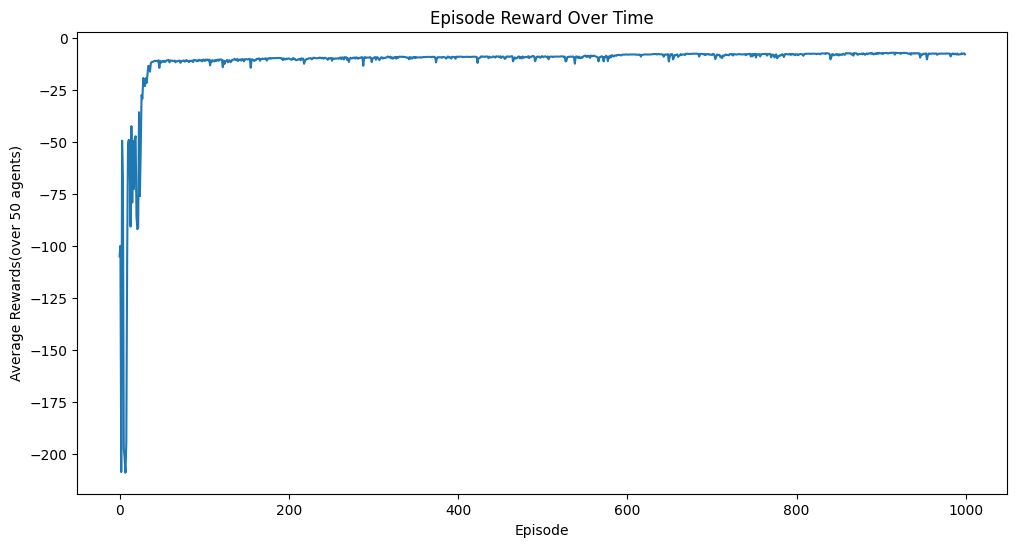

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

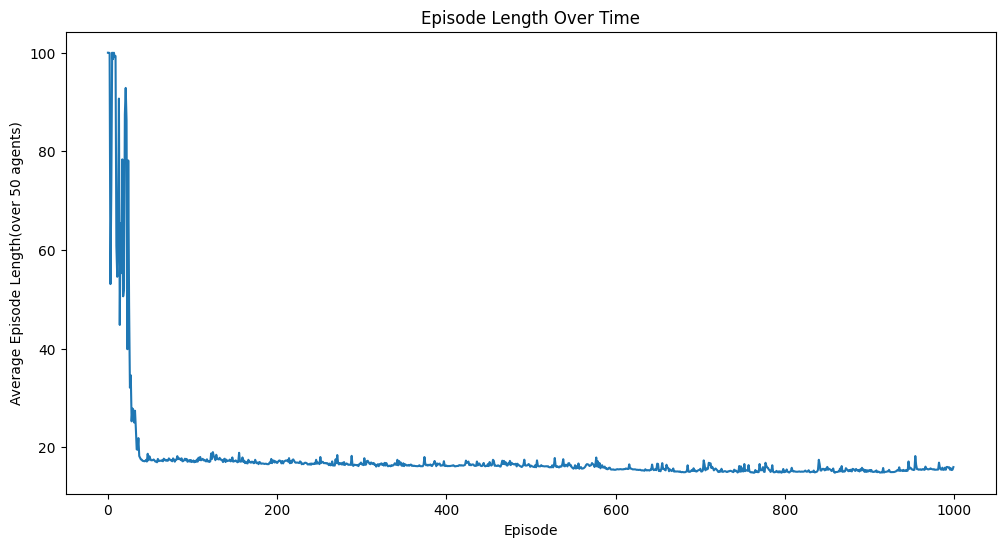

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

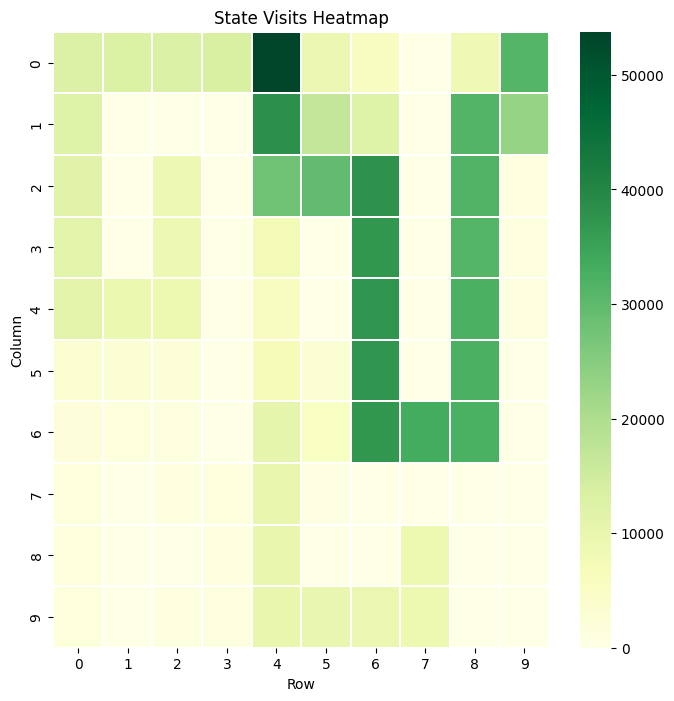

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

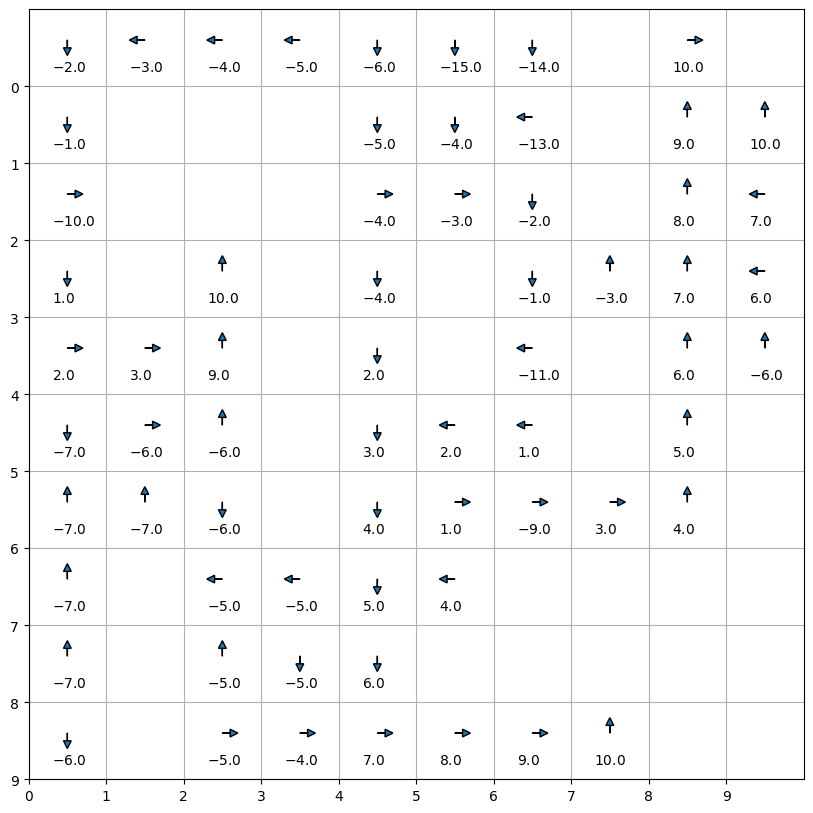

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (0,4) to the goal state at (0,9), avoiding bad states and resets. *(chooses a safe path)*
<br>
However, following the learnt policy will cause the agent to get stuck and continuously hit an obstruction at (4,7). This could be due to the agent trying to course correct 
to a different goal state
<br>
<br>
The hyperparameters choosen are:
* Gamma [1.0] - The agent values future rewards just as much as immediate rewards.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Epsilon [0.001] - The agent takes exploratory actions only 1% of the time. 

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:1.0
Alpha:1.0
Epsilon:0.001
Temperature:None


### Effects of the Environment
---

With start state **(0,4)** and wind set to **False** following a **deterministic policy(p=1)**;
<br>
SARSA agents choose to go to the goal state at (0,9) a majority of the times.
<br>
The algorithm finds the safest path and avoids bad states.

# Testing the Config               

## [2] Configuration Parameters
### ID: SARSA_D_W-F_S36_E

---
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[3,6]])
wind_ = False
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_sarsa(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='greedy')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 3491.3727657794952 seconds


In [14]:
# Saving the model
np.save('SARSA_D_W-F_S36_E', model)

## Plotting Reward Curves
---

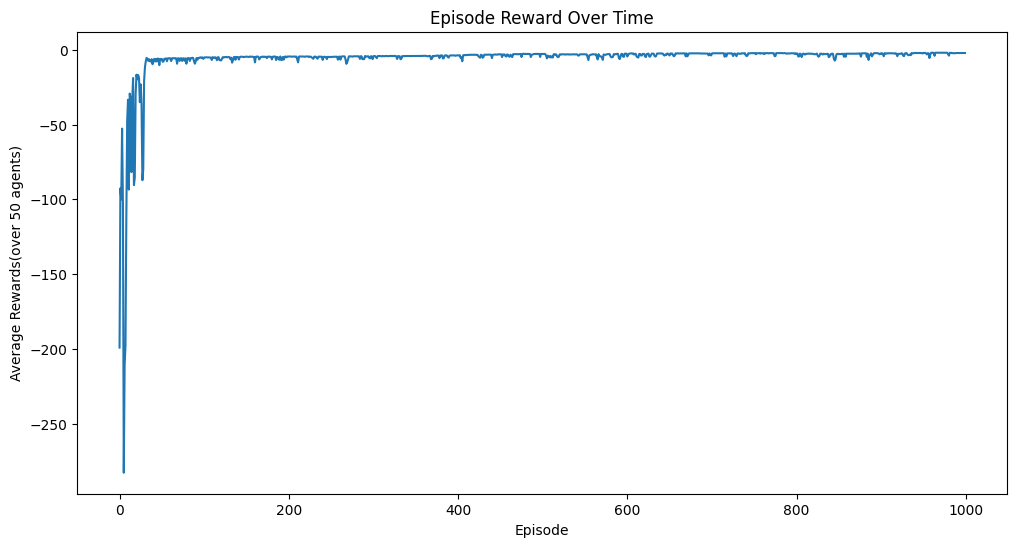

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

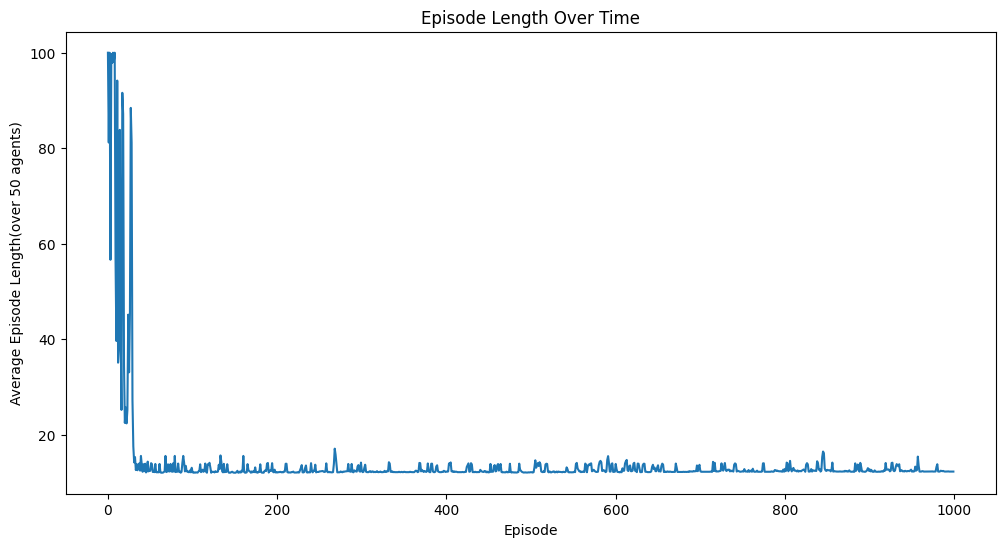

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

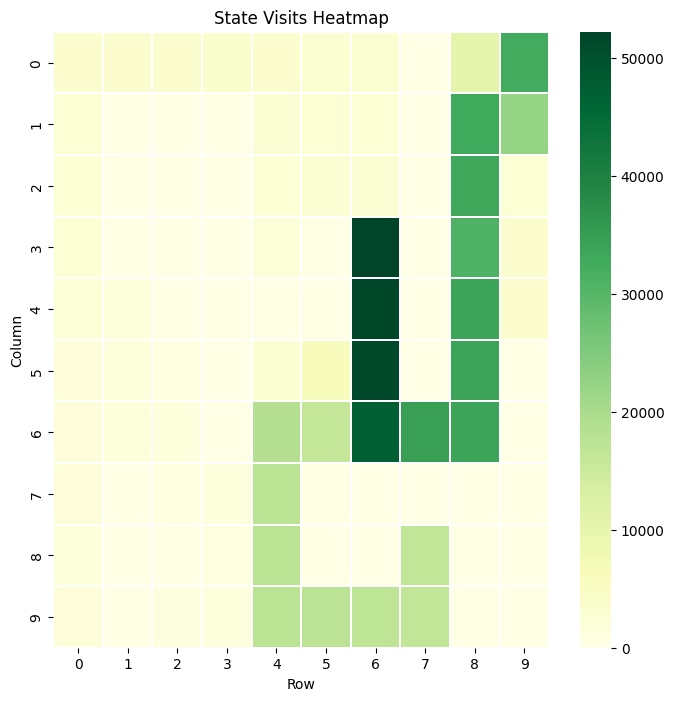

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

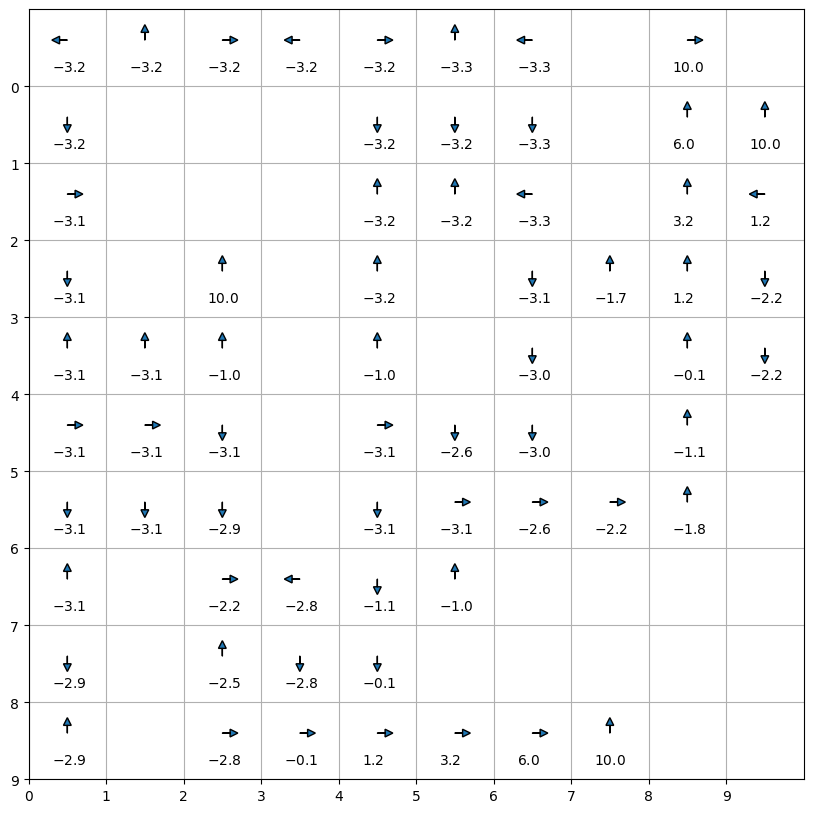

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (3,6) to the goal state at (0,9), avoiding bad states and resets. *(chooses a safe path)*
<br>
Following the policy from the start state will lead to the agent the goal state in the minimum number of steps.
The policy prioritises avoiding bad states over all else
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.7] - The agent values future rewards less than immediate rewards. It picked the lowest value of the gamma hyperparameter.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Epsilon [0.001] - The agent takes exploratory actions only 1% of the time.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.7
Alpha:1.0
Epsilon:0.001
Temperature:None


### Effects of the Environment
---

With start state **(3,6)** and wind set to **False** following a **deterministic policy(p=1)**;
<br>
SARSA agents choose to go to the goal state at (0,9) a majority of the times. The goal at (8,7) was also visited a fair number of times.
<br>
The algorithm finds the safest path and avoids bad states.

# Testing the Config               

## [3] Configuration Parameters
### ID: SARSA_D_W-T_S04_E

---
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[0,4]])
wind_ = True
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_sarsa(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='greedy')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 4288.829686164856 seconds


In [14]:
# Saving the model
np.save('SARSA_D_W-T_S04_E.npy', model)

## Plotting Reward Curves
---

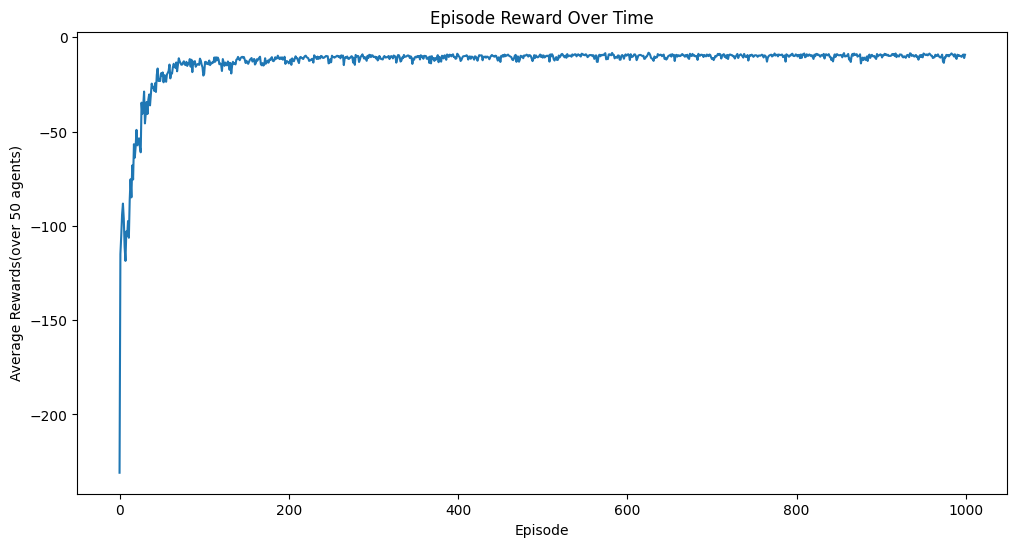

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

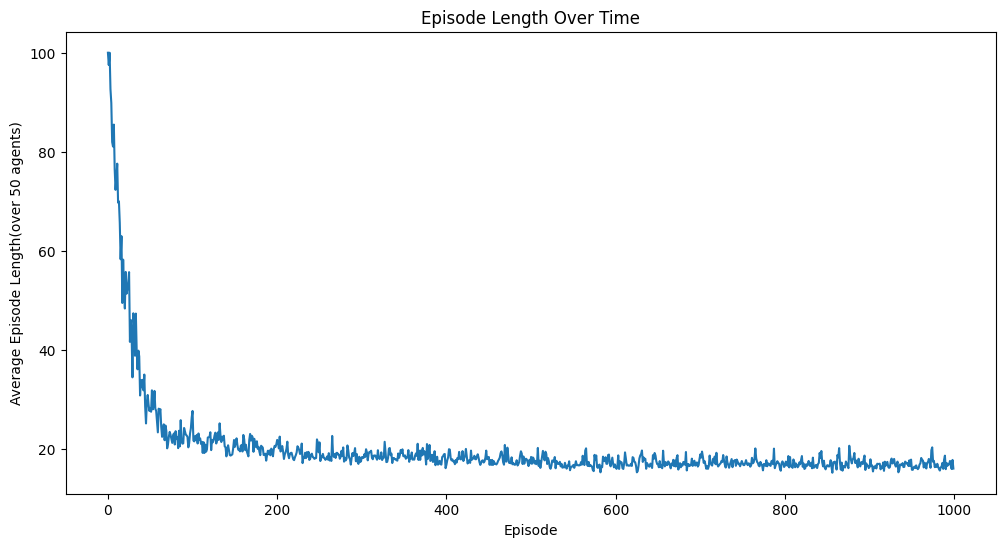

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

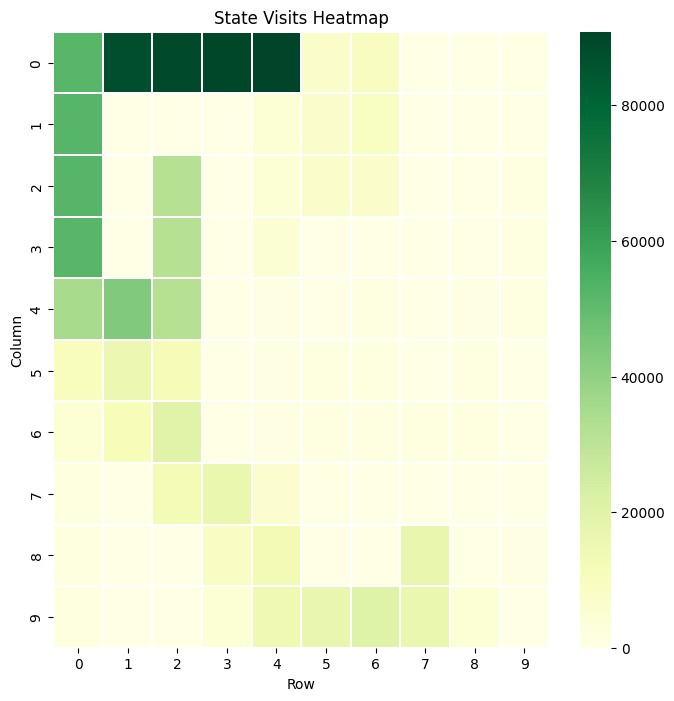

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

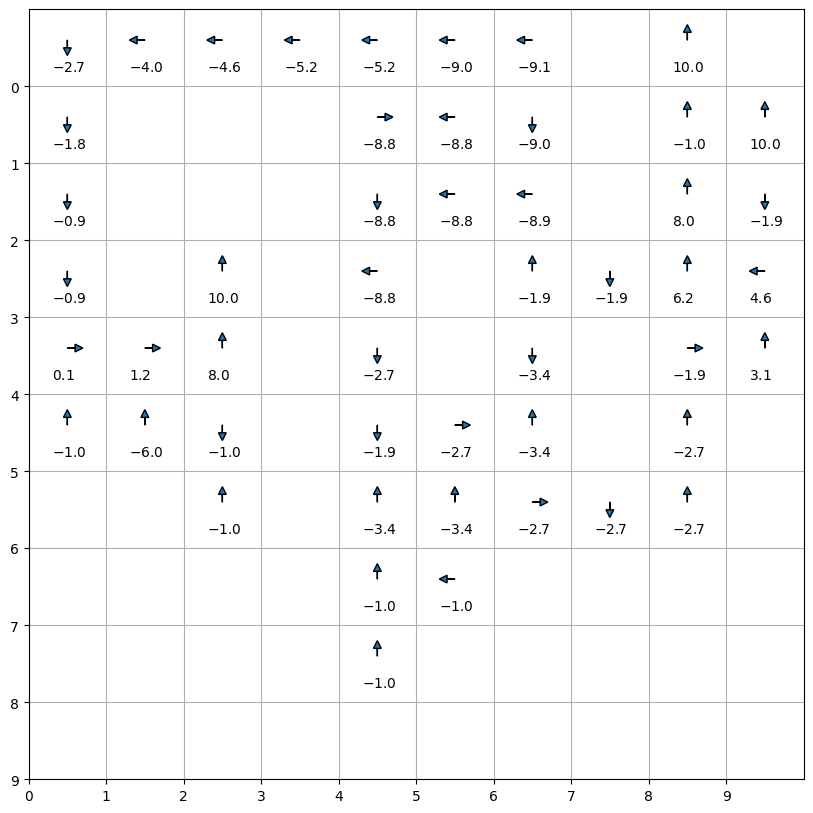

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (0,4) to the goal state at (2,2), passing through a bad state at (2,4). *(chooses an unsafe but shorter path)*
<br>
This policy also almost completely avoided the lower part of the gridworld.
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.9] - The agent values future rewards almost as much as immediate rewards.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Epsilon [0.001] - The agent takes exploratory actions only 1% of the time.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.9
Alpha:1.0
Epsilon:0.001
Temperature:None


### Effects of the Environment
---

With start state **(0,4)** and wind set to **True** following a **deterministic policy(p=1)**;
<br>
SARSA agents choose to go to the goal state at (2,2) a majority of the times. The agent passes through a bad state on its way to the goal.
<br>
Setting wind to **True** causes the agent to behave less safely, choosing shorter paths through bad states.
<br>
The algorithm also avoids the lower part of the gridworld.

# Testing the Config               

## [4] Configuration Parameters
### ID: SARSA_D_W-T_S36_E

---
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[3,6]])
wind_ = True
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_sarsa(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='greedy')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 2412.9442925453186 seconds


In [14]:
# Saving the model
np.save('SARSA_D_W-T_S36_E.npy', model)

## Plotting Reward Curves
---

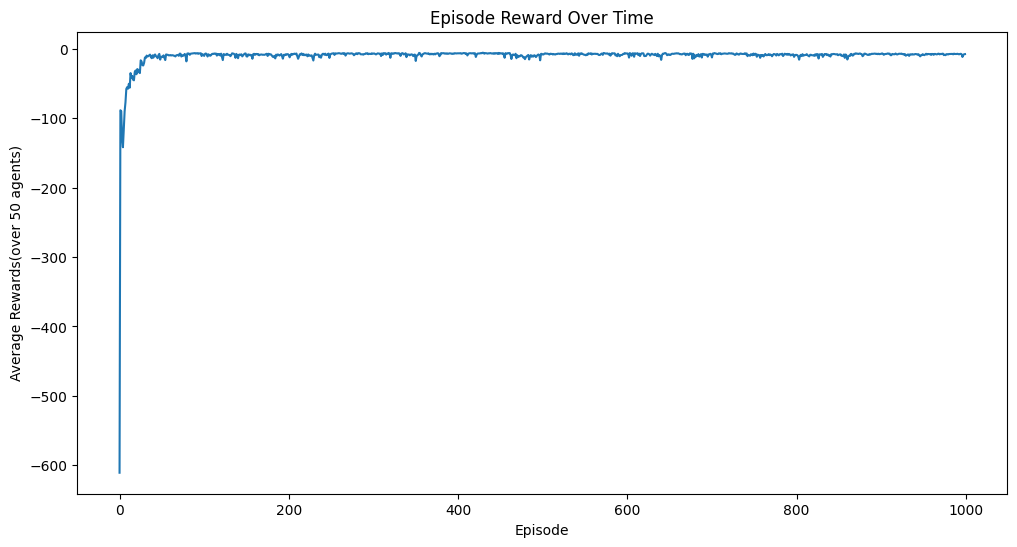

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

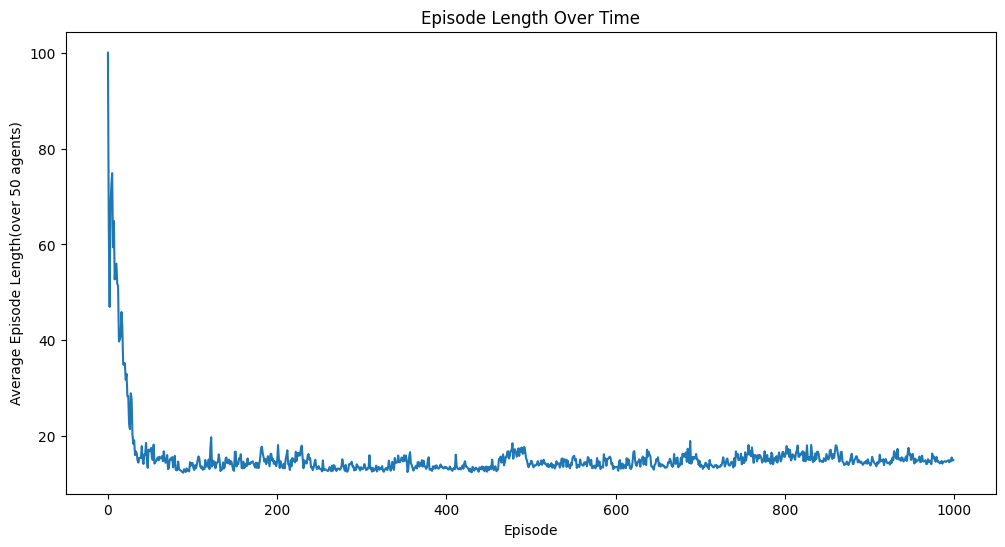

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

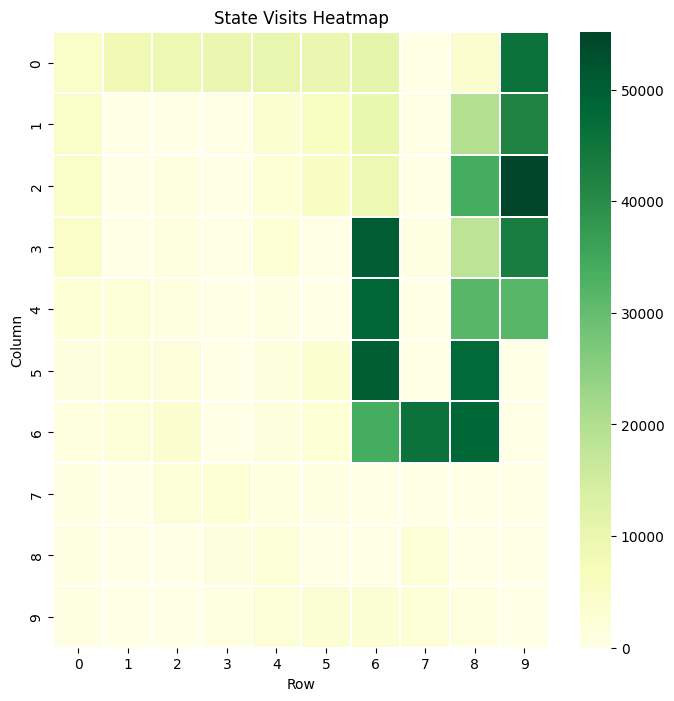

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

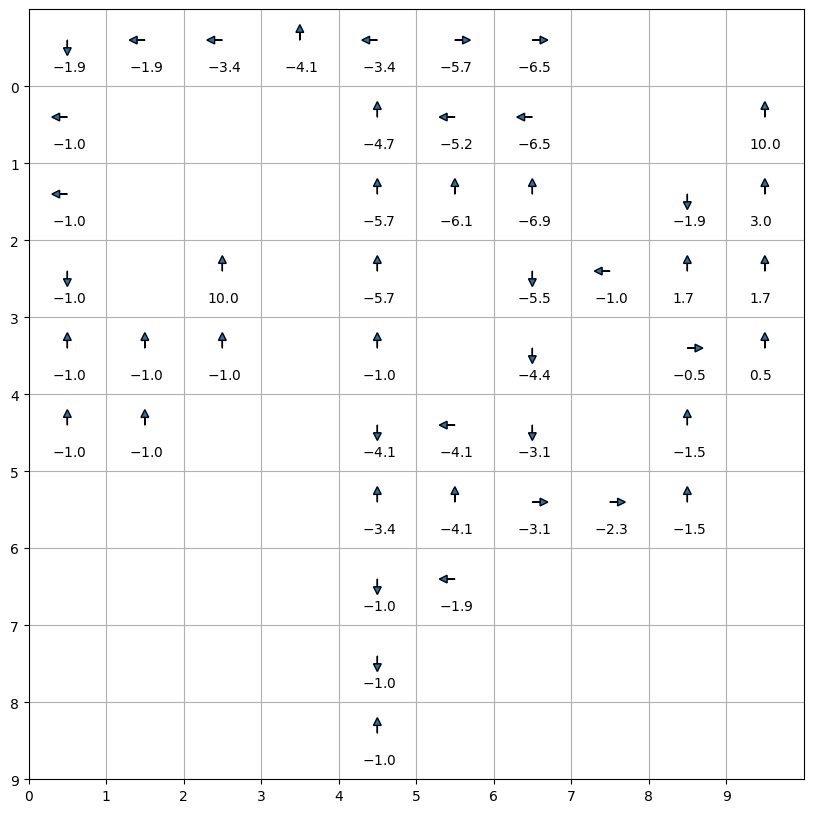

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (3,6) to the goal state at (0,9), going through bad states. *(chooses an unsafe path)*
<br>
The algorithm did not explore the lower part of the girdworld.
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.9] - The agent values future rewards almost as much as immediate rewards.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Epsilon [0.001] - The agent takes exploratory actions only 1% of the time.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.9
Alpha:1.0
Epsilon:0.001
Temperature:None


### Effects of the Environment
---

With start state **(3,6)** and wind set to **True** following a **deterministic policy(p=1)**;
<br>
SARSA agents choose to go to the goal state at (0,9) a majority of the times. The agent passes through a bad state on its way to the goal.
<br>
Setting wind to **True** causes the agent to behave less safely, choosing shorter paths through bad states.
<br>
The algorithm also avoids the lower part of the gridworld.

# Testing the Config               

## [5] Configuration Parameters
### ID: SARSA_D_W-F_S04_S

---
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[0,4]])
wind_ = False
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_sarsa(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='softmax')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 9384.98685669899 seconds


In [14]:
# Saving the model
np.save('SARSA_D_W-F_S04_S.npy', model)

## Plotting Reward Curves
---

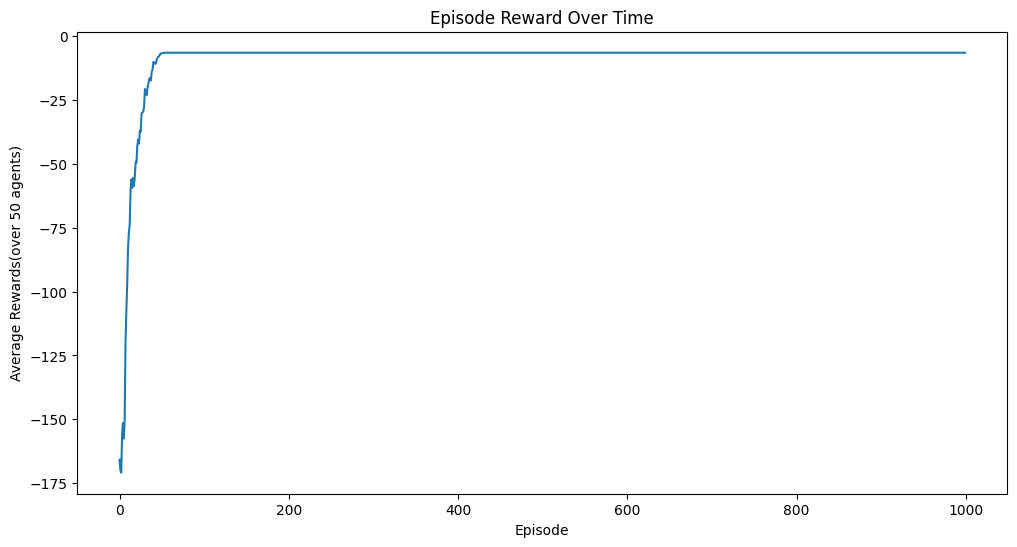

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

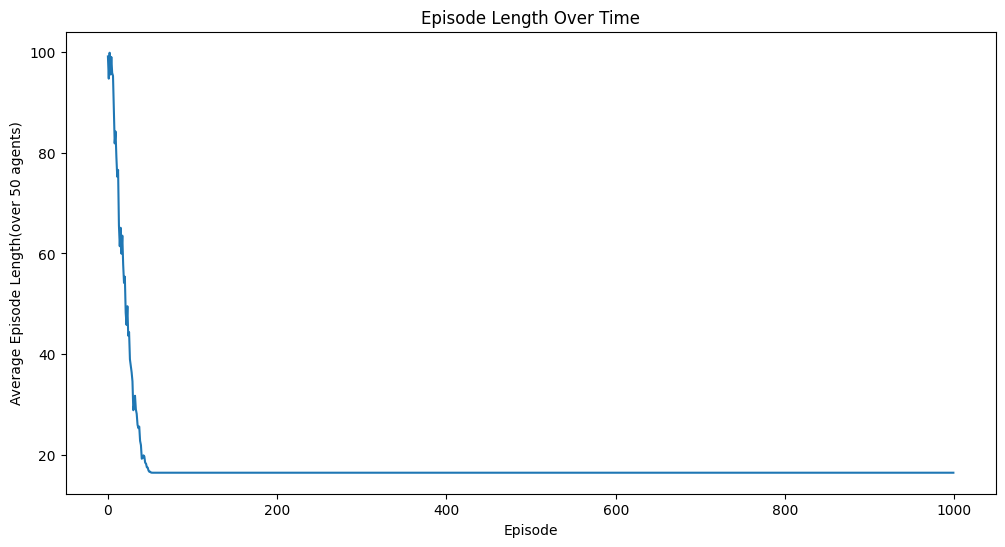

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

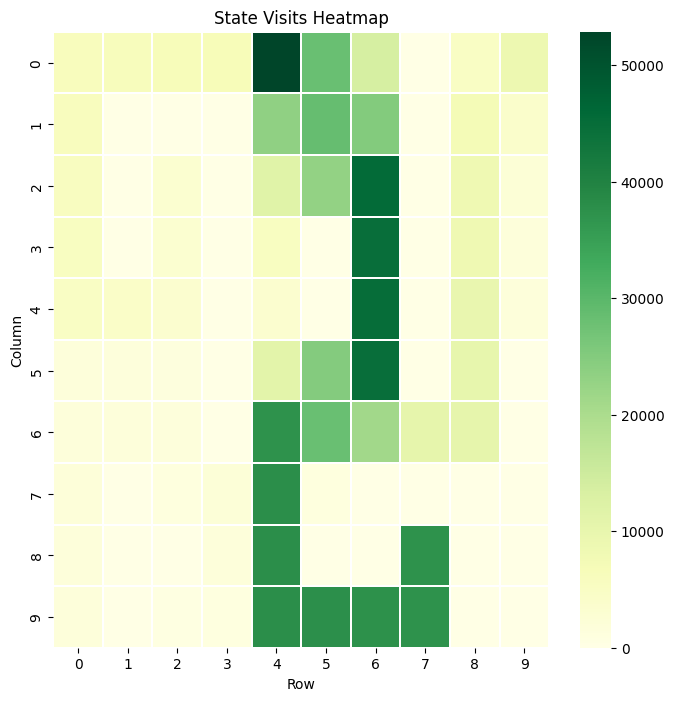

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

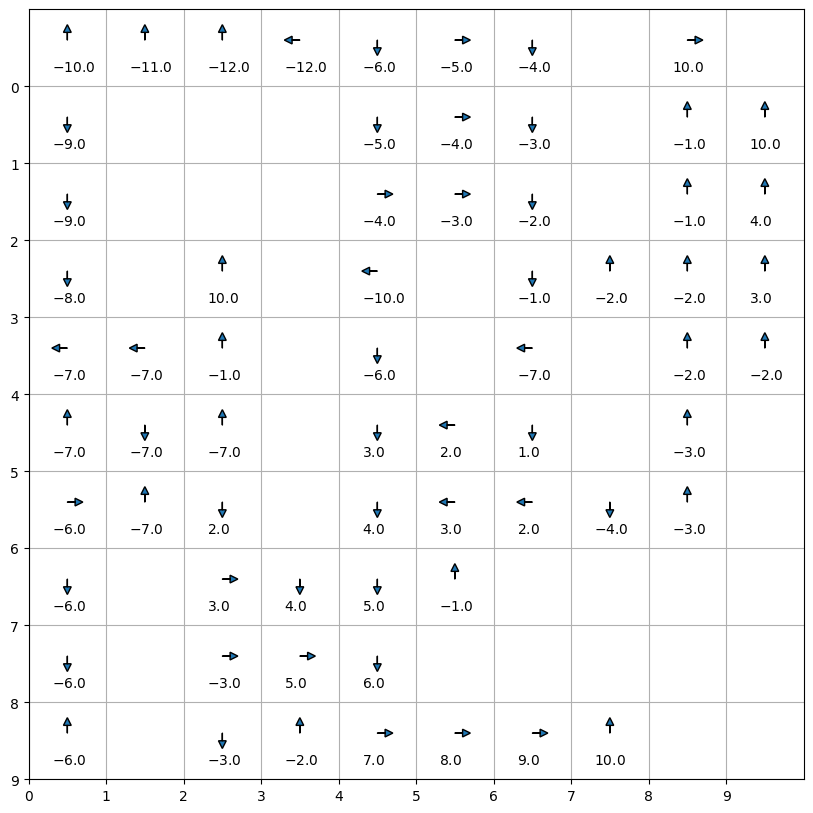

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (0,4) to the goal state at (0,9), avoiding bad states and resets. *(chooses a safe path)*
<br>
However, following the learnt policy to get stuck and continuously hit an obstruction at (4,7). This could be due to the agent trying to course correct 
to a different goal state
<br>
<br>
The hyperparameters choosen are:
* Gamma [1.0] - The agent values future rewards just as much as immediate rewards.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Temperature [0.01] - The agent is very confident in its predictions. It chooses the lowest value of this hyperparameter and there is 
little variation in the rewards earned by the agent across episodes (Once it has decided on a good enough path). 

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:1.0
Alpha:1.0
Epsilon:None
Temperature:0.01


### Effects of the Environment
---

With start state **(0,4)** and wind set to **False** following a **deterministic policy(p=1)**;
<br>
SARSA agents choose to go to the goal state at (8,7) a majority of the times.
<br>
The algorithm finds the safest path and avoids bad states.

# Testing the Config               

## [6] Configuration Parameters
### ID: SARSA_D_W-F_S36_S

---
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[3,6]])
wind_ = False
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_sarsa(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='softmax')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 11080.489116668701 seconds


In [14]:
# Saving the model
np.save('SARSA_D_W-F_S36_S.npy', model)

## Plotting Reward Curves
---

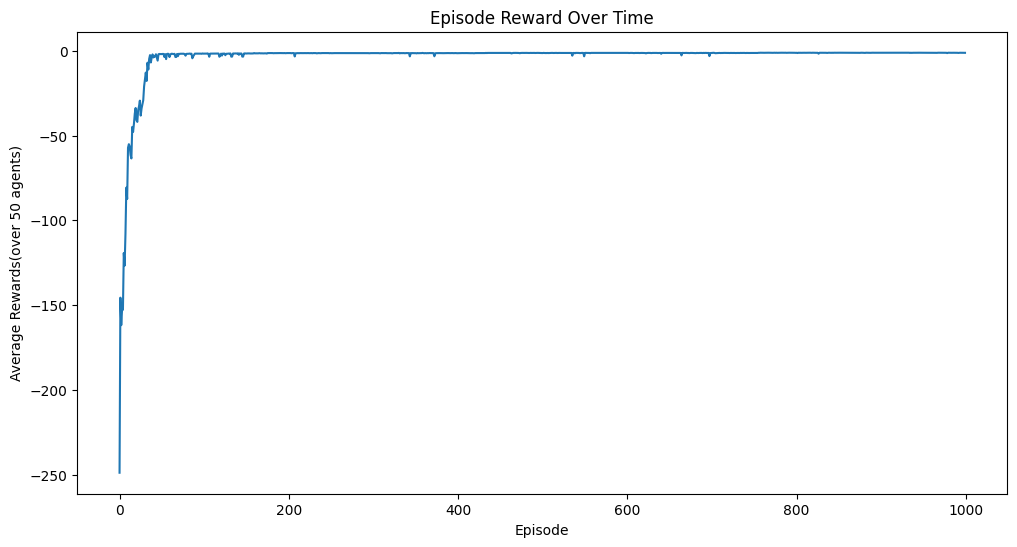

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

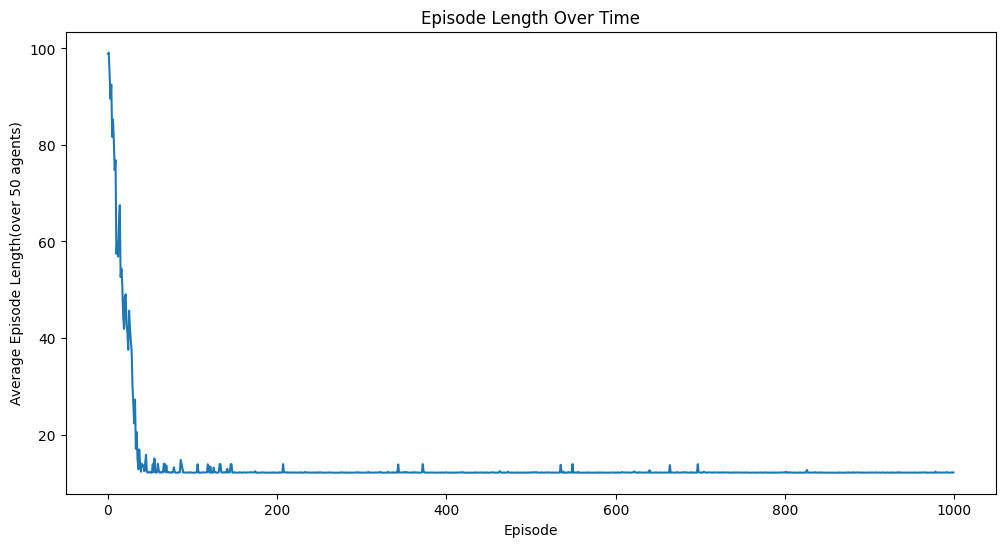

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

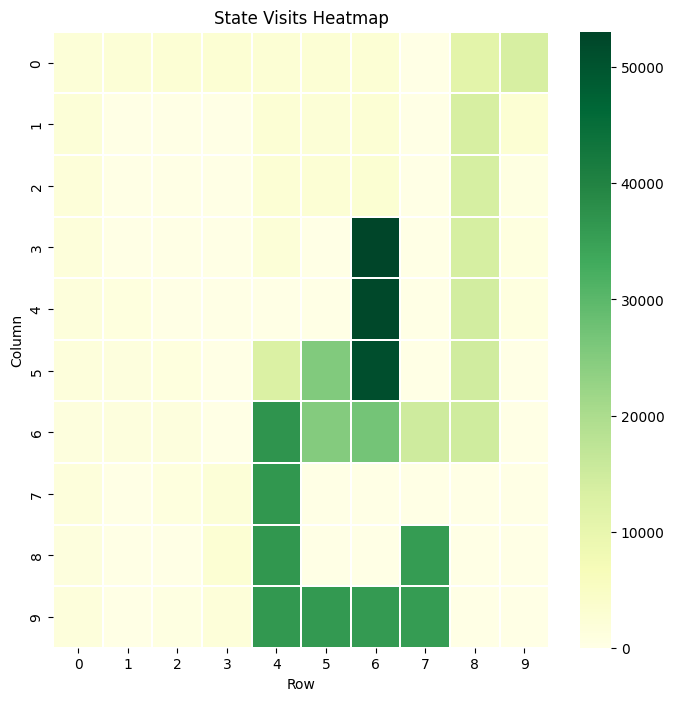

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

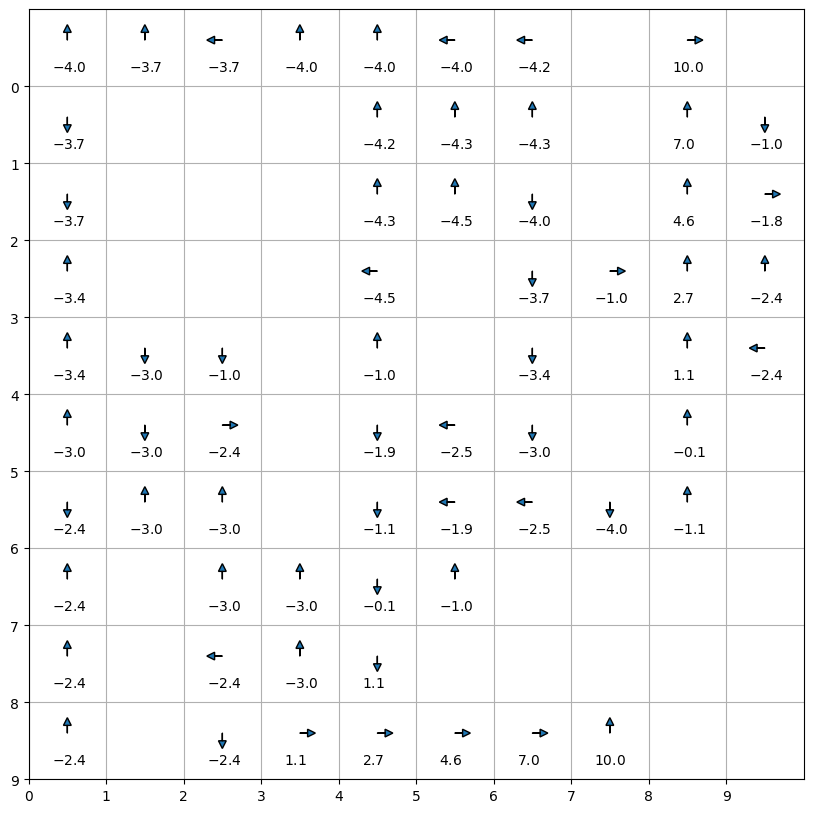

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (3,6) to the goal state at (8,7), avoiding bad states and resets. *(chooses a safe path)*
<br>
Following the policy from the start state will lead to the agent the goal state in the minimum number of steps.
The policy prioritises avoiding bad states over all else
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.8] - The agent values future rewards less than immediate rewards.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Temperature [0.1] - The agent is somewhat confident in its predictions. It chooses the a low value of this hyperparameter and there is 
some variation in the rewards earned by the agent across episodes (Once it has decided on a good enough path). 

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.8
Alpha:1.0
Epsilon:None
Temperature:0.1


### Effects of the Environment
---

With start state **(3,6)** and wind set to **False** following a **deterministic policy(p=1)**;
<br>
SARSA agents choose to go to the goal state at (8,7) a majority of the times.
<br>
The algorithm finds the safest path and avoids bad states.

# Testing the Config               

## [7] Configuration Parameters
### ID: SARSA_D_W-T_S04_S

---
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[0,4]])
wind_ = True
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_sarsa(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='softmax')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 11184.573776006699 seconds


In [14]:
# Saving the model
np.save('SARSA_D_W-T_S04_S.npy', model)

## Plotting Reward Curves
---

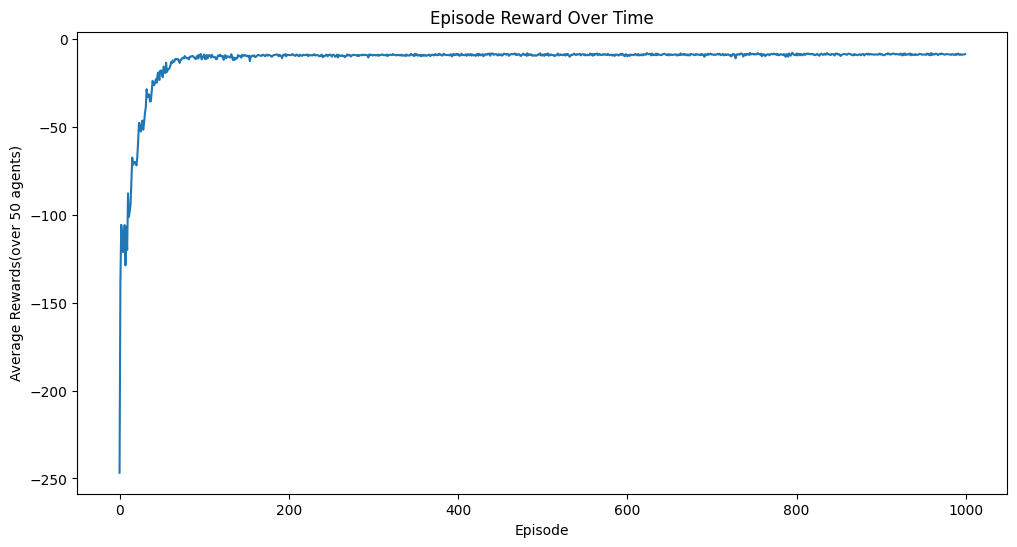

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

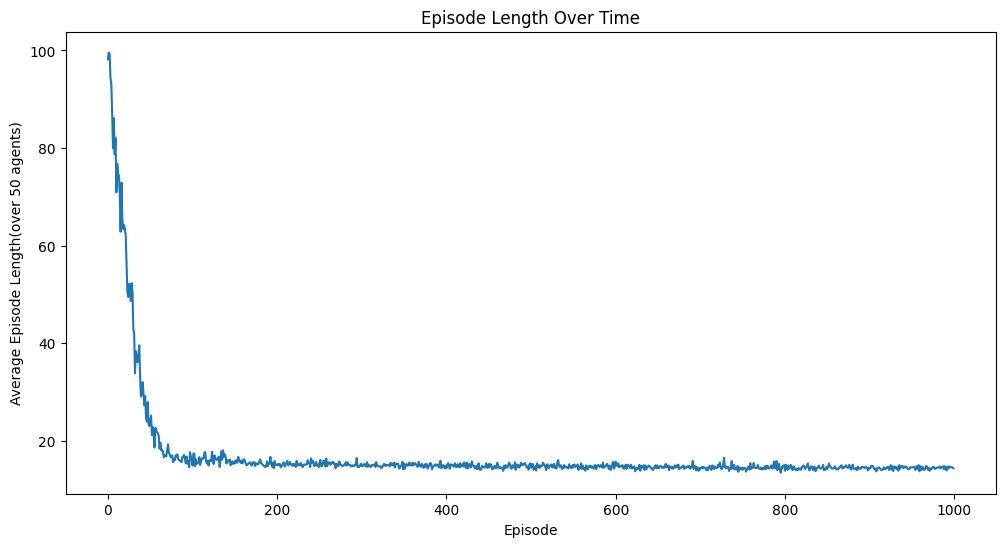

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

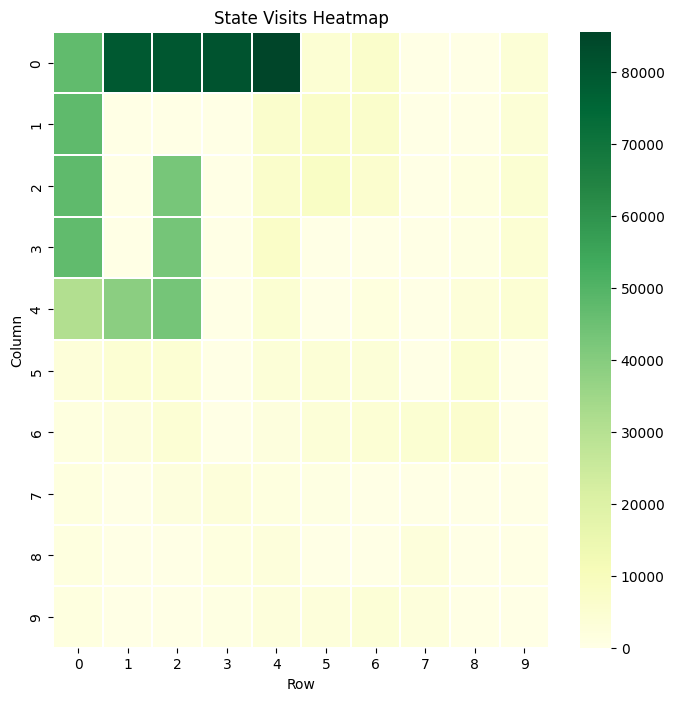

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

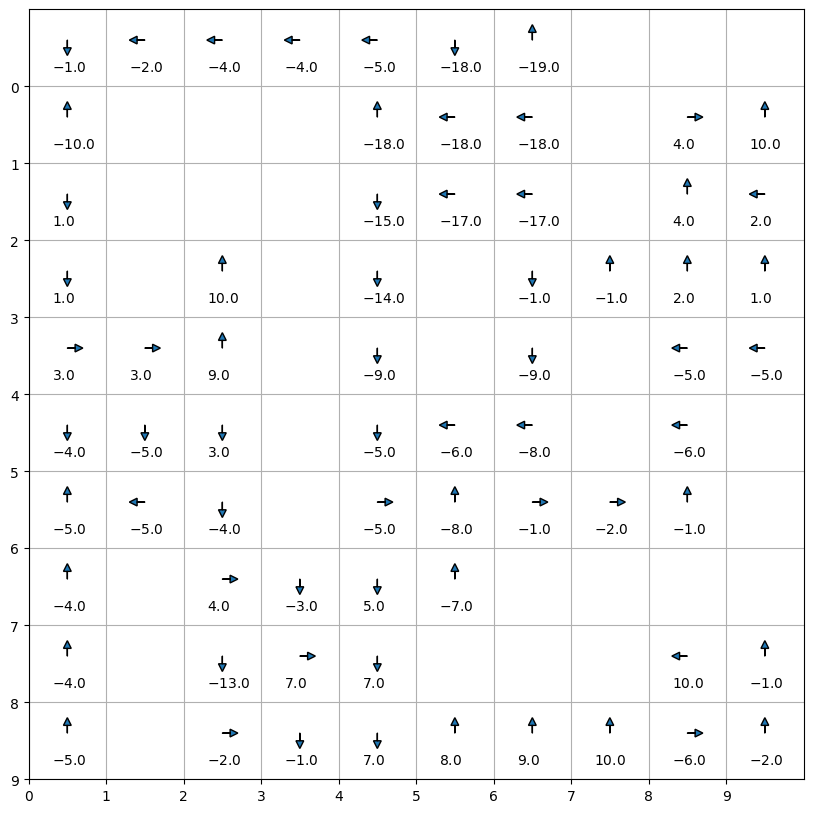

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (0,4) to the goal state at (2,2), going through a bad states. *(chooses an unsafe)*
<br>
However, following the learnt policy will cause the agent to get stuck and oscillate between the cells (0,0) and (0,1). This is likely due to the high alpha value.
<br>
<br>
The hyperparameters choosen are:
* Gamma [1.0] - The agent values future rewards just as much as immediate rewards.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Temperature [0.01] - The agent is very confident in its predictions. It chooses the lowest value of this hyperparameter and there is 
little variation in the rewards earned by the agent across episodes (Once it has decided on a good enough path). The variation we observe is likely due to wind being True.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:1.0
Alpha:1.0
Epsilon:None
Temperature:0.01


### Effects of the Environment
---

With start state **(0,4)** and wind set to **True** following a **deterministic policy(p=1)**;
<br>
SARSA agents choose to go to the goal state at (2,2) a majority of the times. The agent passes through a bad state on its way to the goal.
<br>
Setting wind to **True** causes the agent to behave less safely, choosing shorter paths through bad states.

# Testing the Config               

## [8] Configuration Parameters
### ID: SARSA_D_W-T_S36_S

---
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[3,6]])
wind_ = True
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_sarsa(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='softmax')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 9742.278701782227 seconds


In [14]:
# Saving the model
np.save('SARSA_D_W-T_S36_S.npy', model)

## Plotting Reward Curves
---

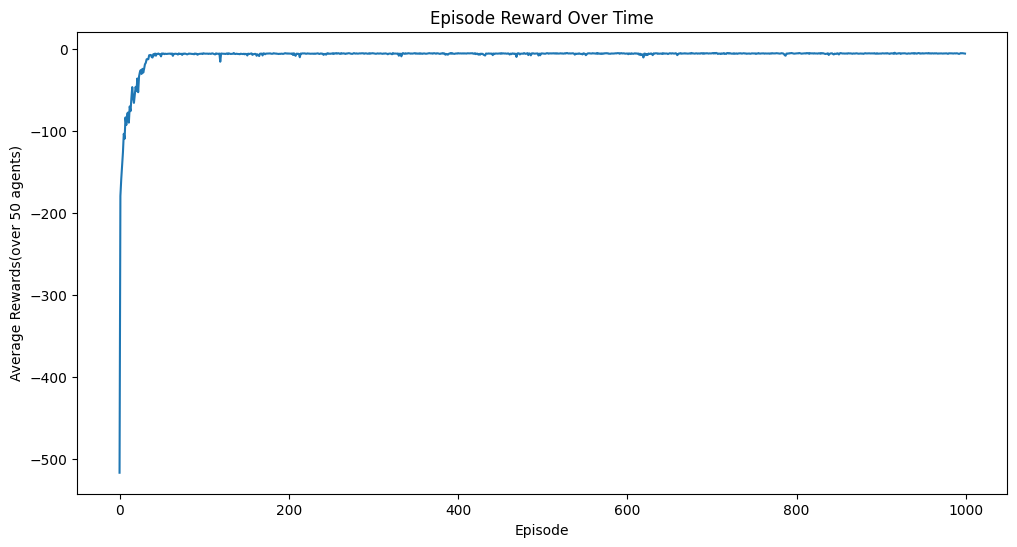

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

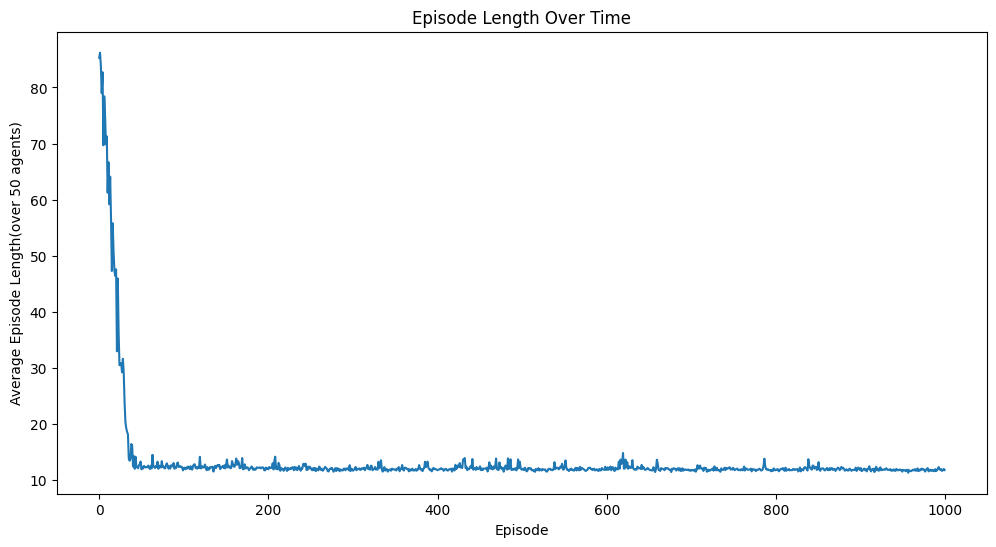

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

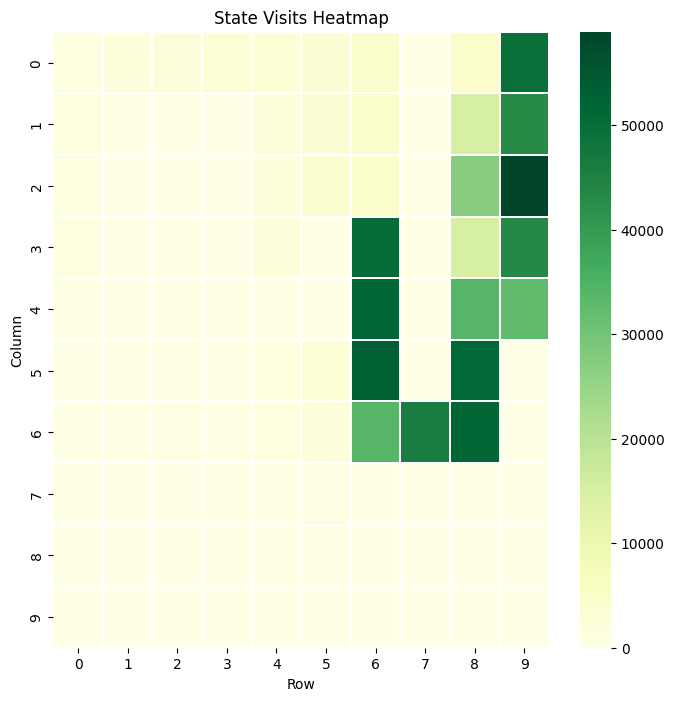

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

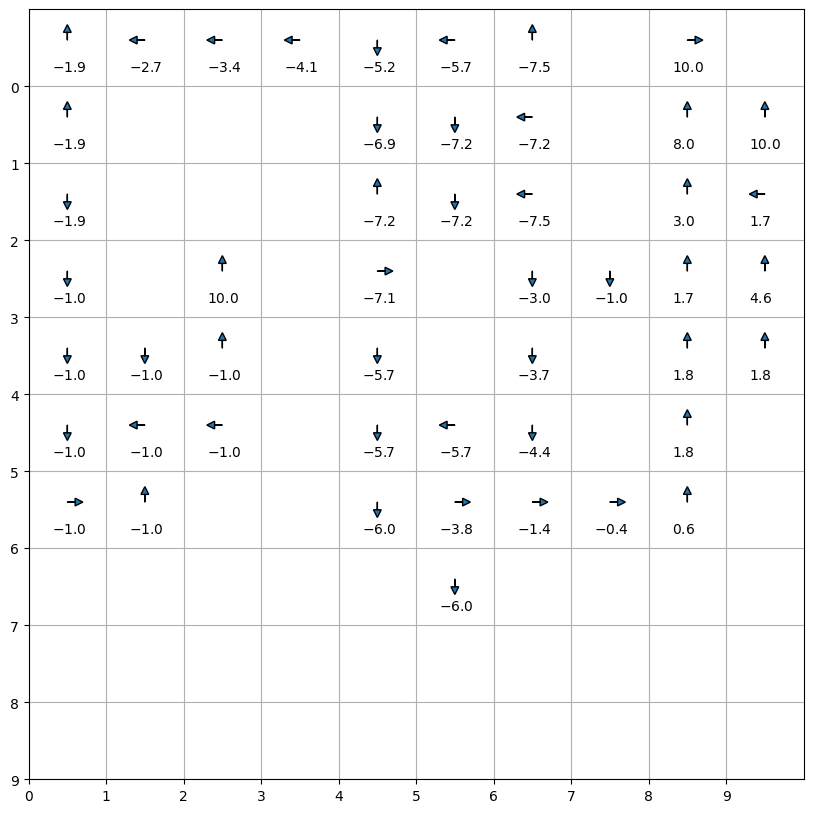

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (3,6) to the goal state at (0,9), avoiding bad states and resets. *(chooses a safe path)*
<br>
Following the policy gives the agent the shortest safe path to the goal state. 
<br>
The agent avoided exploring the lower part of the gridworld.
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.9] - The agent values future rewards almost as much as immediate rewards.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Temperature [0.01] - The agent is very confident in its predictions. It chooses the lowest value of this hyperparameter and there is 
little variation in the rewards earned by the agent across episodes (Once it has decided on a good enough path). The variation we observe in the rewards earned is likely due to wind being true.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.9
Alpha:1.0
Epsilon:None
Temperature:0.01


### Effects of the Environment
---

With start state **(3,6)** and wind set to **True** following a **deterministic policy(p=1)**;
<br>
SARSA agents choose to go to the goal state at (2,2) a majority of the times. The agent passes through a bad state on its way to the goal.
<br>
Setting wind to **True** here however does not cause the agent to behave less safely. It still avoids bad states.
<br>
The algorithm also avoids the lower part of the gridworld.

# Testing the Config               

## [9] Configuration Parameters
### ID: QLEARNING_D_W-F_S04_E

---
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[0,4]])
wind_ = False
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_qlearning(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='greedy')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 3887.97602391243 seconds


In [14]:
# Saving the model
np.save('QLEARNING_D_W-F_S04_E.npy', model)

## Plotting Reward Curves
---

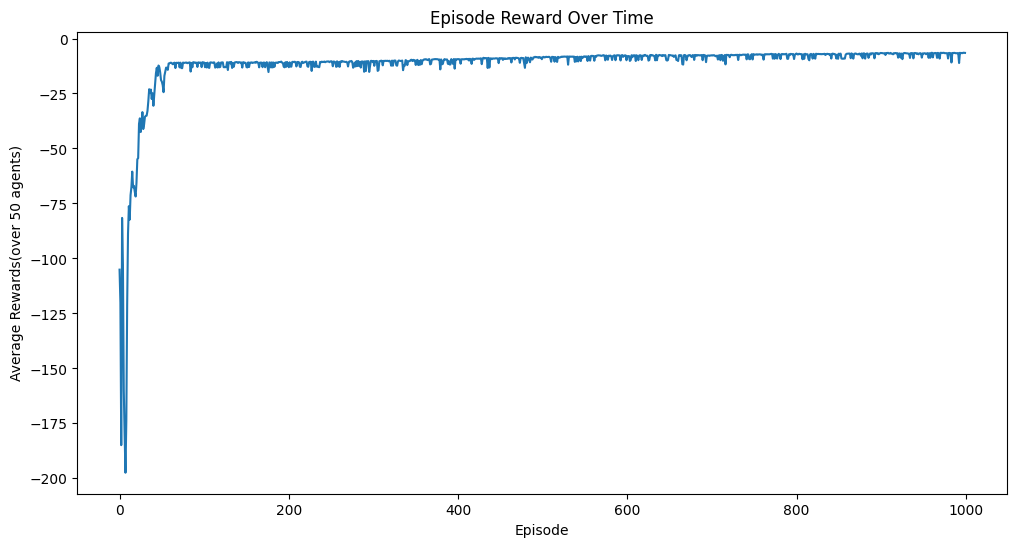

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

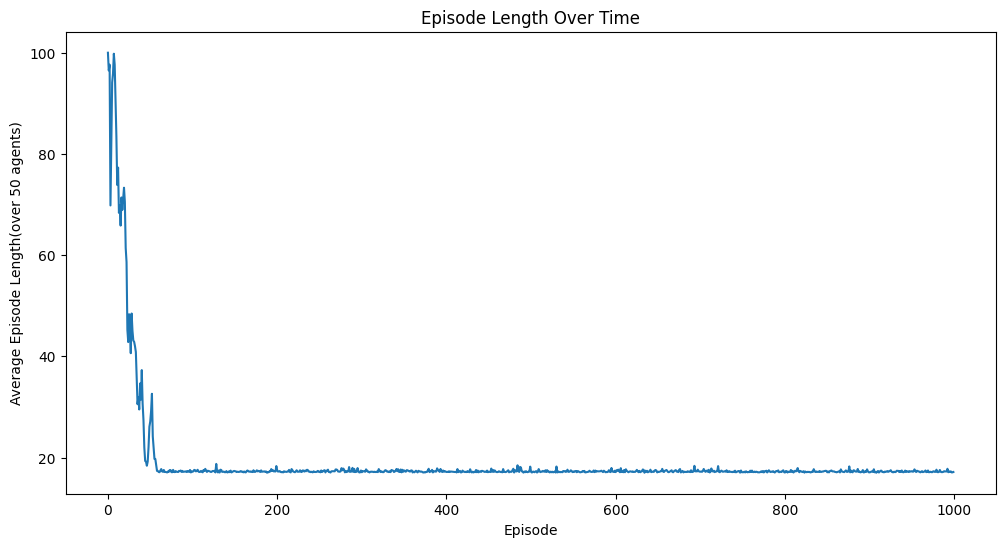

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

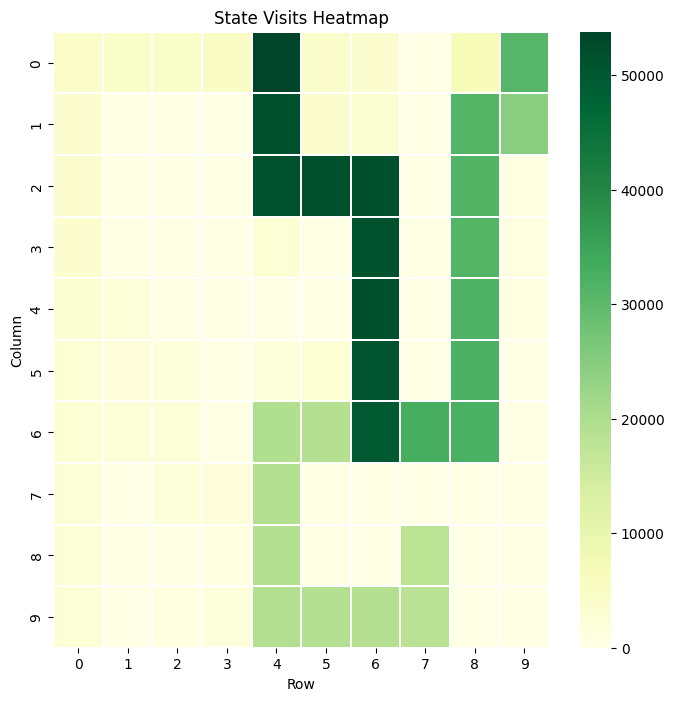

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

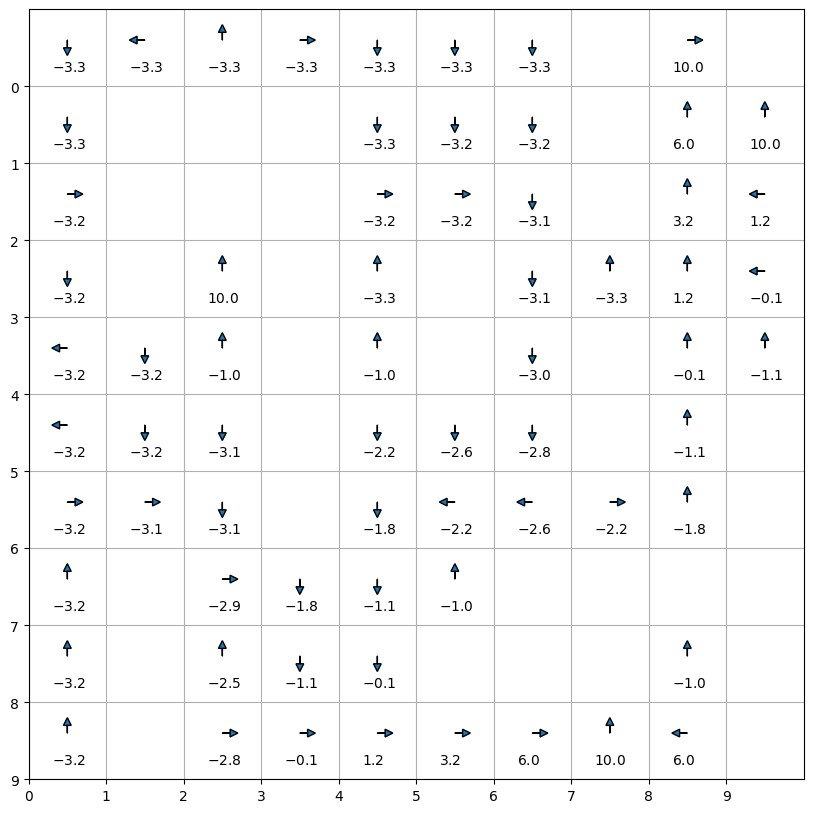

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (0,4) to the goal state at (8,7), avoiding bad states and resets. *(chooses a safe path)*
<br>
The policy finds the a longer path to one of the goal states.
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.7] - The agent values future rewards less than immediate rewards. It chooses the lowest value of this hyperparameter.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Epsilon [0.01] - The agent takes exploratory actions only 1% of the time.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.7
Alpha:1.0
Epsilon:0.01
Temperature:None


### Effects of the Environment
---

With start state **(0,4)** and wind set to **False** following a **deterministic policy(p=1)**;
<br>
Q-Learning agents choose to go to the goal state at (8,7) a majority of the times. The agent follows a safe path to its goal.
<br>

# Testing the Config               

## [10] Configuration Parameters
### ID: QLEARNING_D_W-F_S04_S

---
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[0,4]])
wind_ = False
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_qlearning(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='softmax')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 11836.531417369843 seconds


In [14]:
# Saving the model
np.save('QLEARNING_D_W-F_S04_S.npy', model)

## Plotting Reward Curves
---

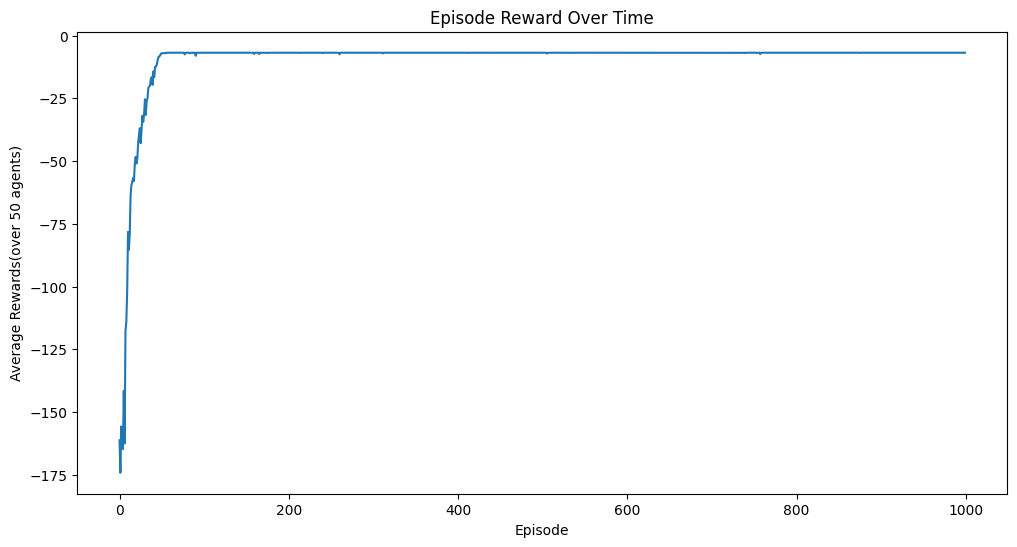

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

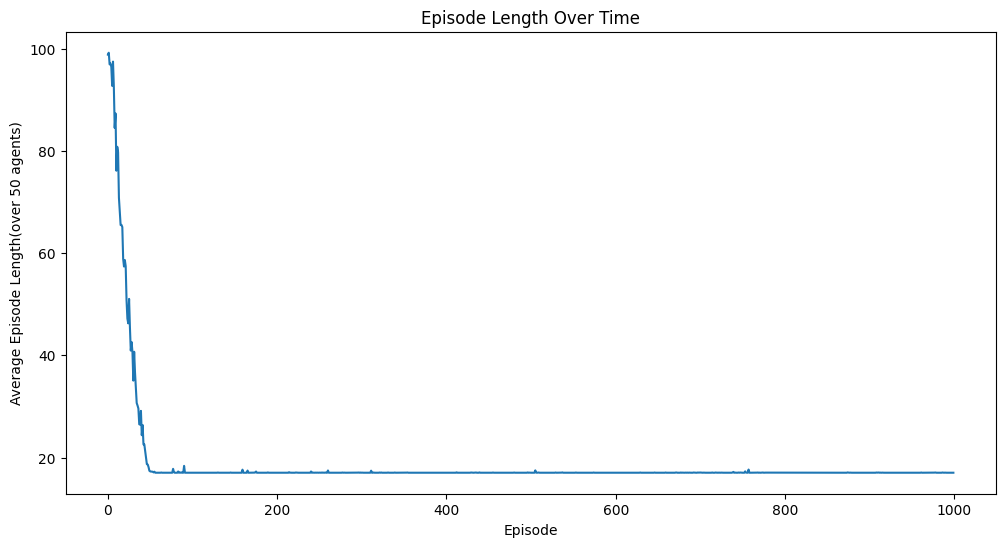

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

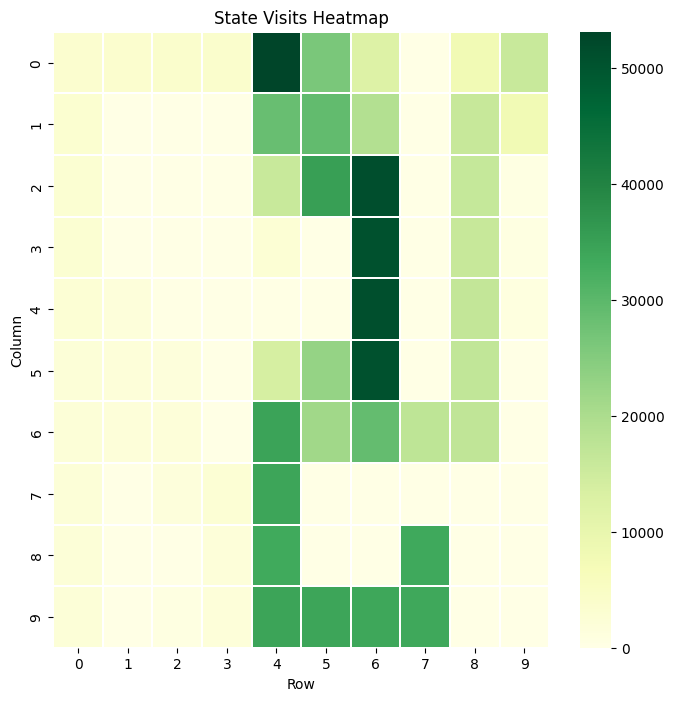

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

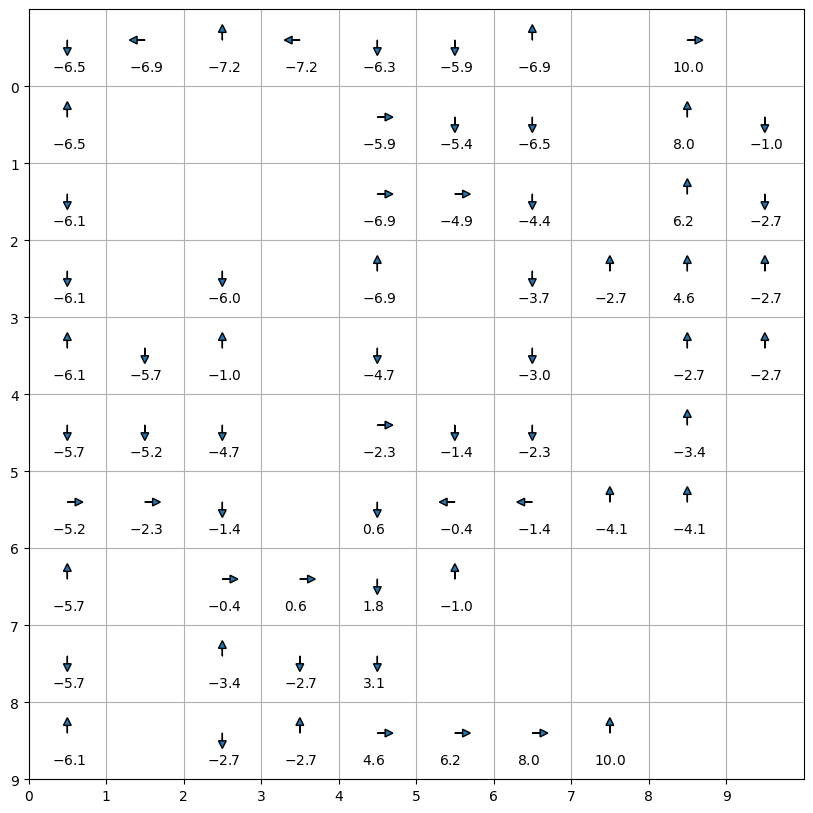

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (0,4) to the goal state at (8,7), avoiding bad states and resets. *(chooses a safe path)*
<br>
The policy finds the shortest safe path to the goal state.
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.9] - The agent values future rewards almost as much as immediate rewards. 
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Temperature [0.1] - The agent is somewhat condifent in its actions and this leads to less variation in the rewards across episodes.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.9
Alpha:1.0
Epsilon:None
Temperature:0.1


### Effects of the Environment
---

With start state **(0,4)** and wind set to **False** following a **deterministic policy(p=1)**;
<br>
Q-Learning agents choose to go to the goal state at (8,7) a majority of the times. The agent follows a safe path to its goal.
<br>

# Testing the Config               

## [11] Configuration Parameters
### ID: QLEARNING_D_W-F_S36_E

---
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[3,6]])
wind_ = False
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_qlearning(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='greedy')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 2373.5192675590515 seconds


In [14]:
# Saving the model
np.save('QLEARNING_D_W-F_S36_E.npy', model)

## Plotting Reward Curves
---

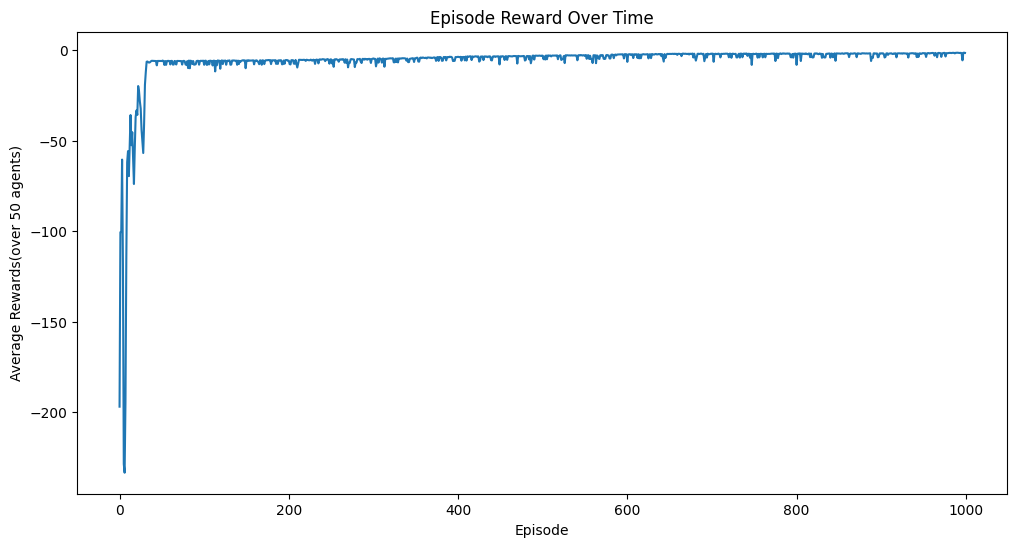

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

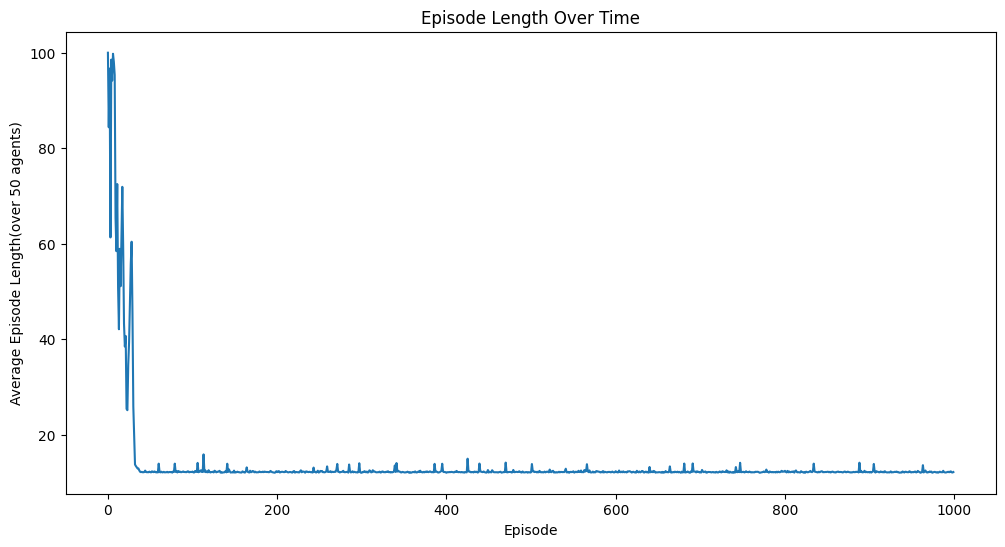

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

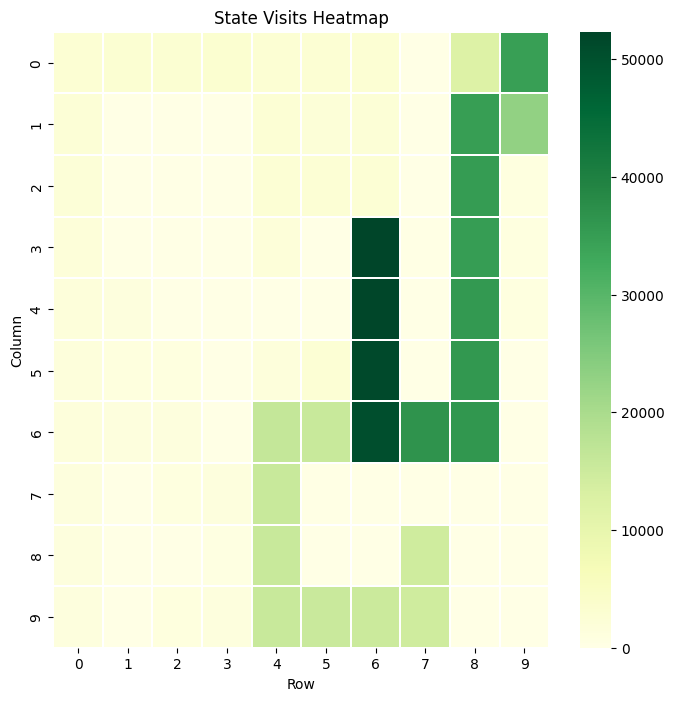

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

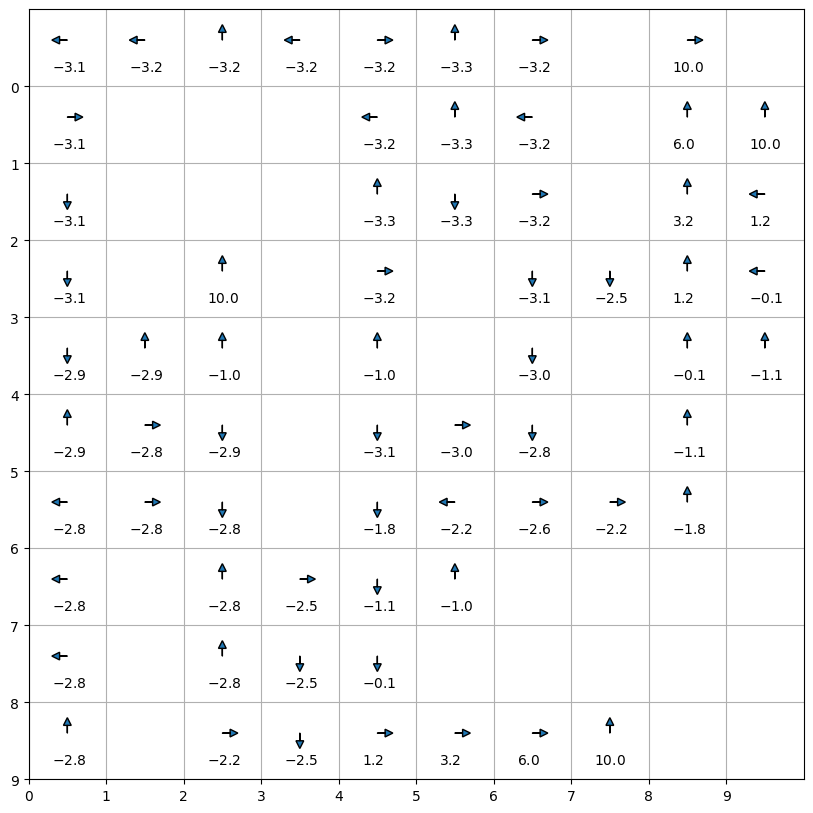

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (3,6) to the goal state at (0,9), avoiding bad states and resets. *(chooses a safe path)*
<br>
The policy finds the shortest safe path to the goal state.
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.7] - The agent values future rewards less than immediate rewards. It chooses the lowest value of this hyperparameter.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Epsilon [0.01] - The agent takes exploratory actions only 1% of the time.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.7
Alpha:1.0
Epsilon:0.01
Temperature:None


### Effects of the Environment
---

With start state **(3,6)** and wind set to **False** following a **deterministic policy(p=1)**;
<br>
Q-Learning agents choose to go to the goal state at (0,9) a majority of the times. The agent follows a safe path to its goal.
<br>

# Testing the Config               

## [12] Configuration Parameters
### ID: QLEARNING_D_W-F_S36_S

---
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[3,6]])
wind_ = False
p = 1

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_qlearning(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='softmax')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 6604.878748416901 seconds


In [14]:
# Saving the model
np.save('QLEARNING_D_W-F_S36_S.npy', model)

## Plotting Reward Curves
---

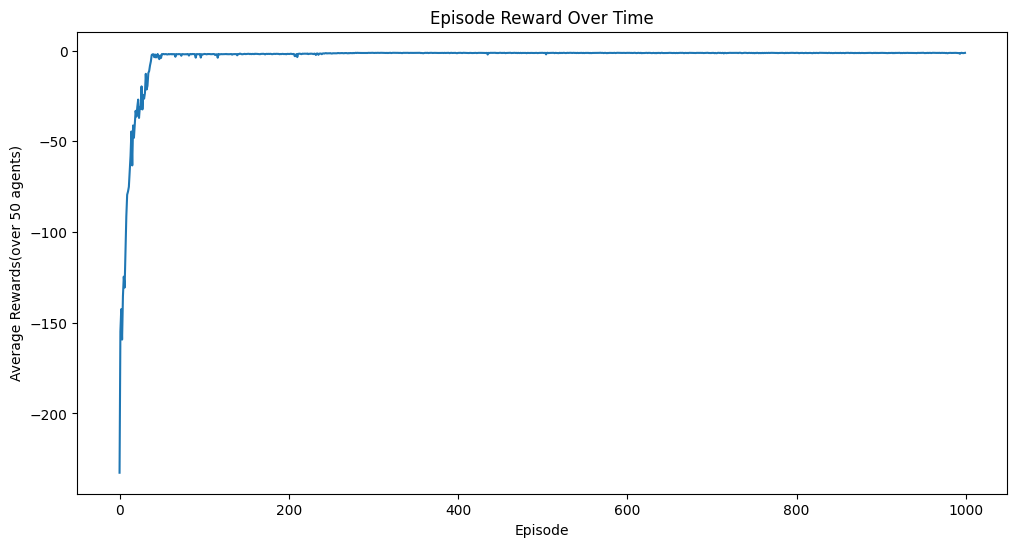

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

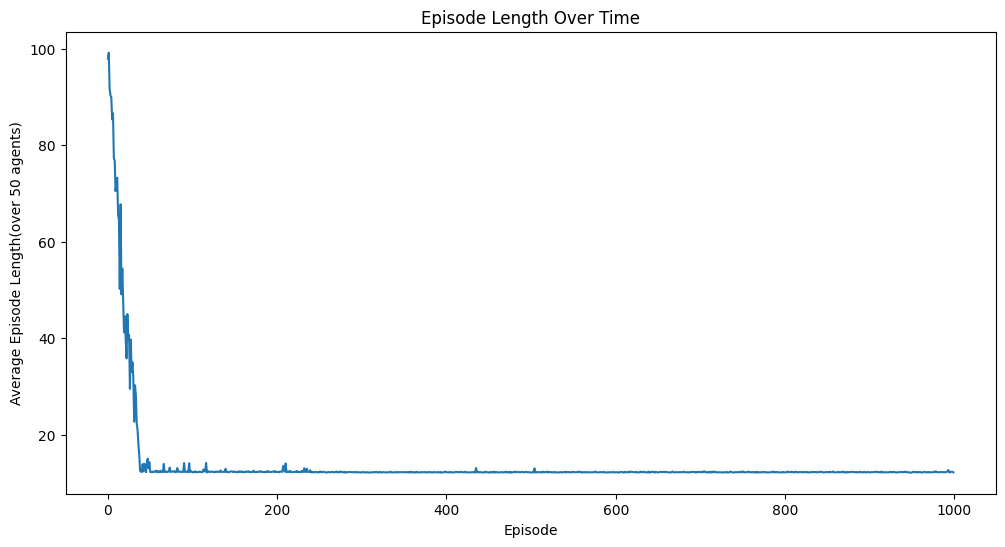

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

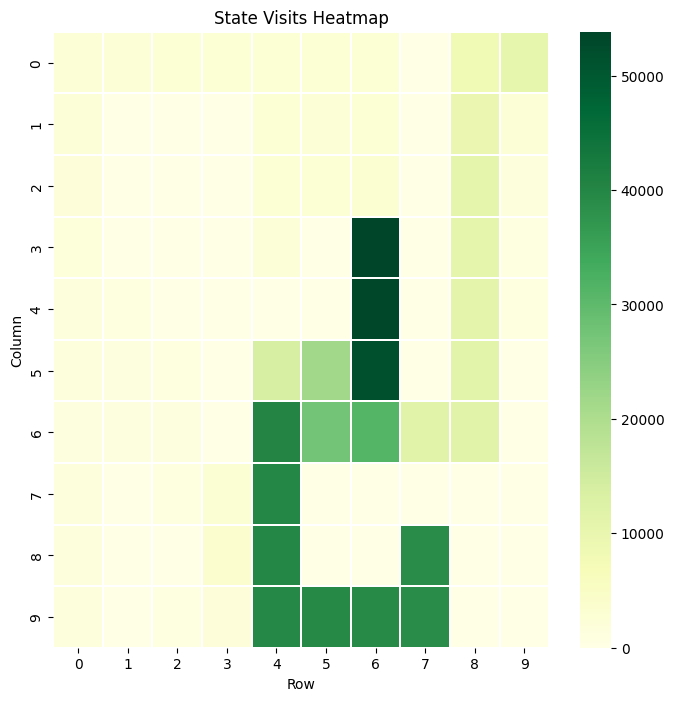

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

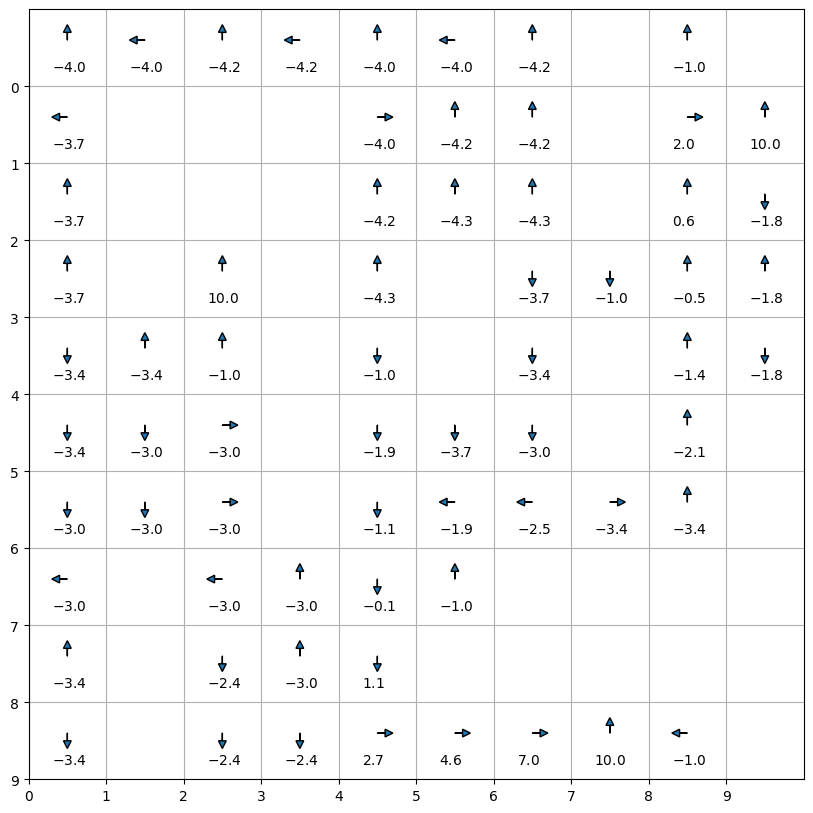

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (3,6) to the goal state at (8,7). Though if the on its way to the (0,9) goal, it 
passes through a bad state.
<br>
The policy finds the shortest safe path to the goal state.
<br>
<br>
The hyperparameters choosen are:
* Gamma [0.8] - The agent values future rewards  somewhat less than immediate rewards. It chooses the lowest value of this hyperparameter.
* Alpha [1.0] - The agent adjusts quickly to the TD error. This might cause it to fluctuate between actions - and thus not converge.
* Temperature [0.01] - The agent is condifent in the actions it takes and this leads to less variability in the rewards across episodes.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:0.8
Alpha:1.0
Epsilon:None
Temperature:0.1


### Effects of the Environment
---

With start state **(3,6)** and wind set to **False** following a **deterministic policy(p=1)**;
<br>
Q-Learning agents choose to go to the goal state at (8,7) a majority of the times. The agent follows a safe path to its goal.
<br>

# Testing the Config               

## [13] Configuration Parameters
### ID: QLEARNING_S_W-F_S04_E

---
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[0,4]])
wind_ = False
p = 0.7

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_qlearning(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='greedy')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 3383.1416437625885 seconds


In [14]:
# Saving the model
np.save('QLEARNING_S_W-F_S04_E.npy', model)

## Plotting Reward Curves
---

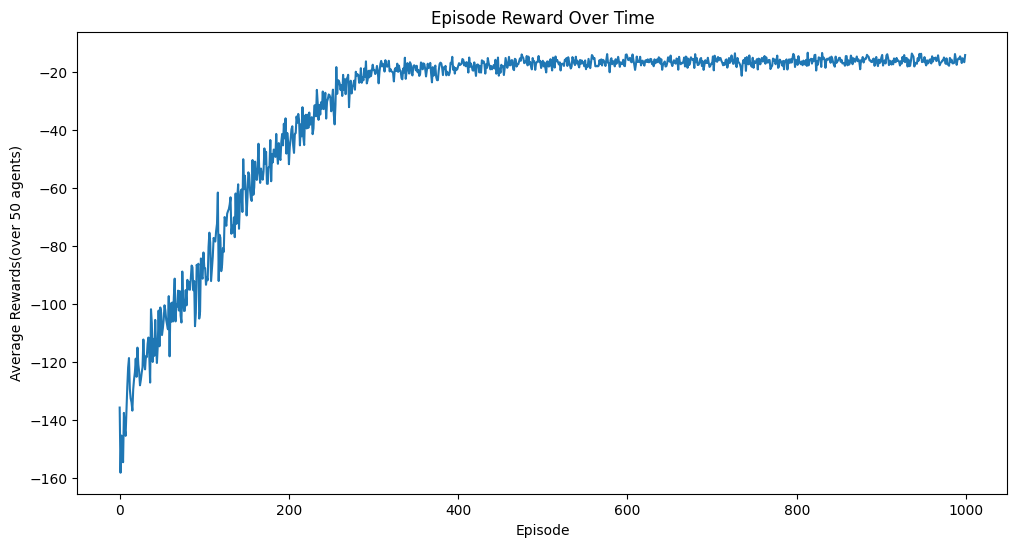

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

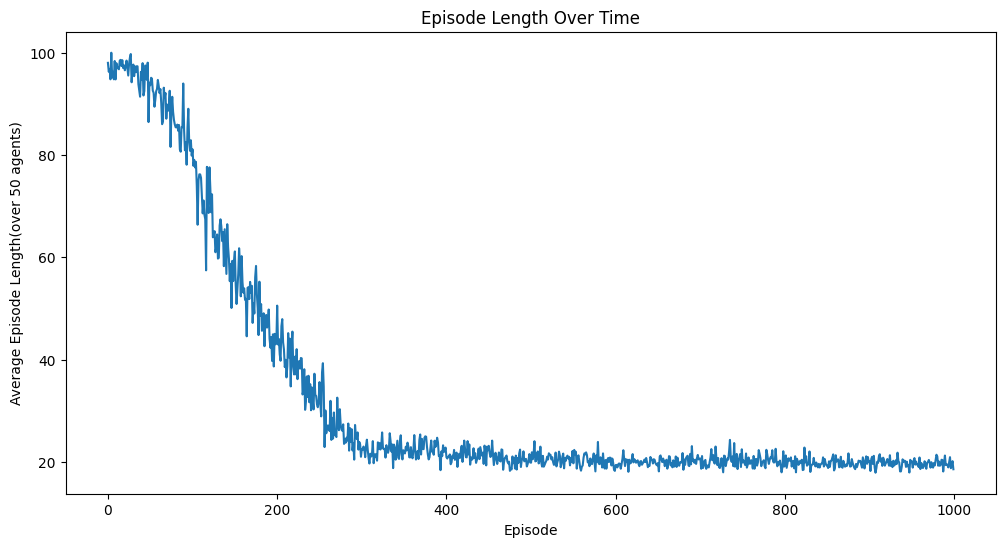

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

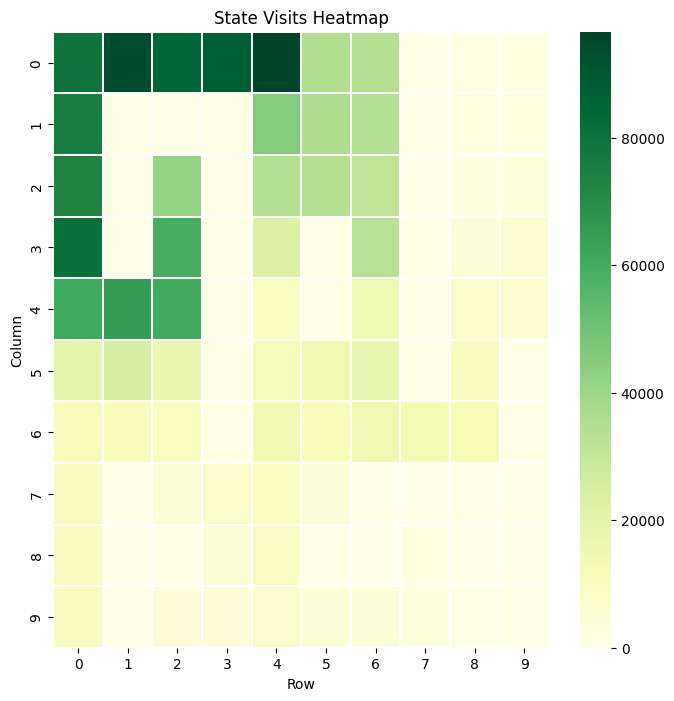

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

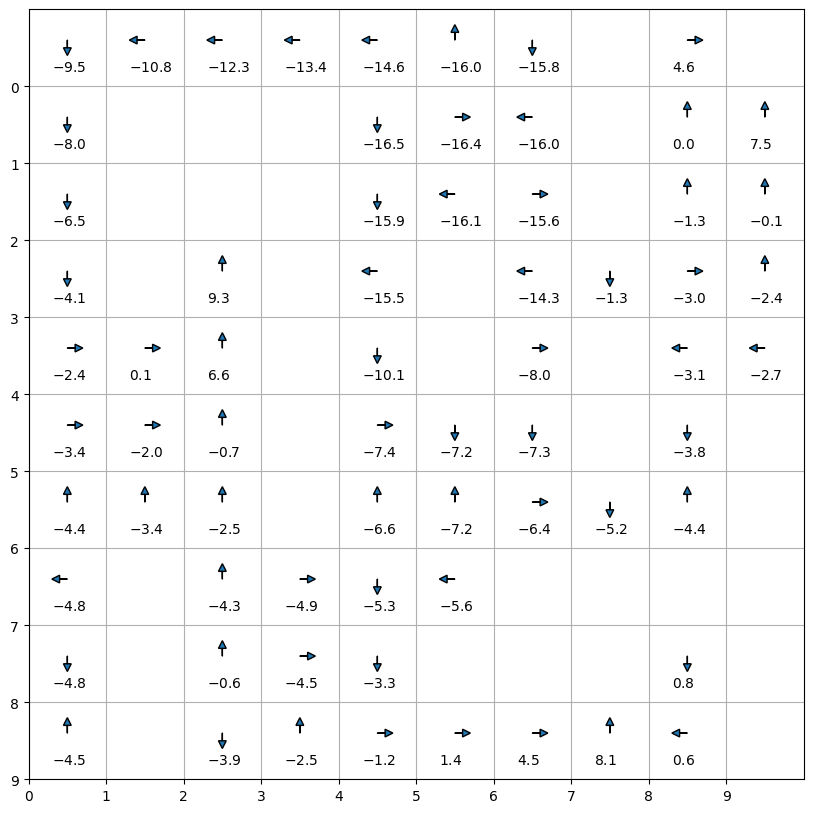

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (0,4) to the goal state at (2,2). It passes through a bad state on its way to the goal.
<br>
The policy finds the shortest safe path to the goal state.
<br>
<br>
The hyperparameters choosen are:
* Gamma [1.0] - The agent values future rewards as much as immediate rewards.
* Alpha [0.1] - The agent adjusts slowly to the TD error. This is likely due to the stochasticity of the environment.
* Epsilon [0.001] - The agent takes exploratory actions only 1% of the times.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:1.0
Alpha:0.1
Epsilon:0.001
Temperature:None


### Effects of the Environment
---

With start state **(0,4)** and wind set to **False** following a **stochastic policy(p=0.7)**;
<br>
Q-Learning agents choose to go to the goal state at (2,2) a majority of the times. The agent follows a safe path to its goal.
<br>
Due to non-deterministic transition probabilities, the agent takes a longer time to settle on an optimal policy. There is great variation in the rewards per episode.

# Testing the Config               

## [14] Configuration Parameters
### ID: QLEARNING_S_W-F_S04_S

---
Learning algorithm = Q-Learning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = softmax

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[0,4]])
wind_ = False
p = 0.7

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_qlearning(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='softmax')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 12872.005893230438 seconds


In [14]:
# Saving the model
np.save('QLEARNING_S_W-F_S04_S.npy', model)

## Plotting Reward Curves
---

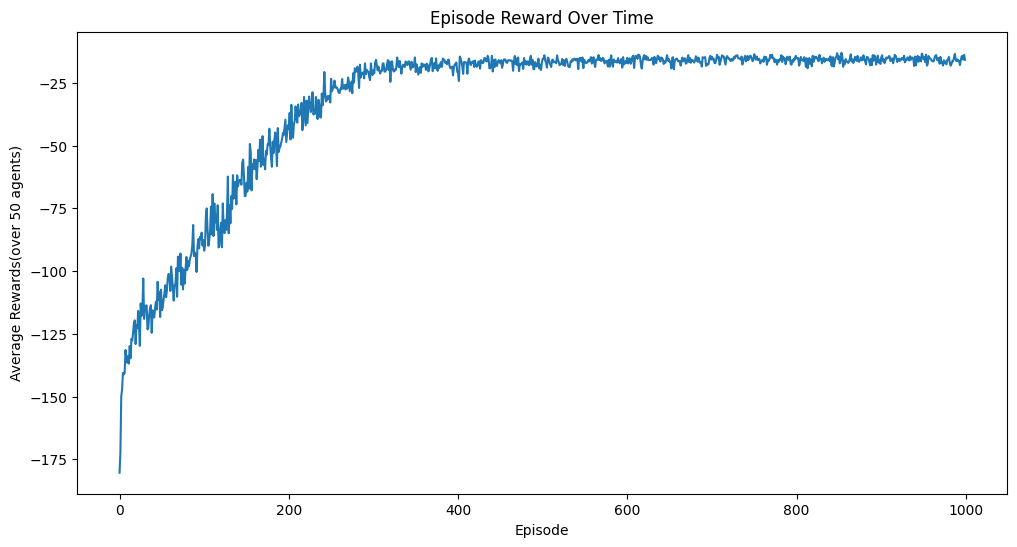

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

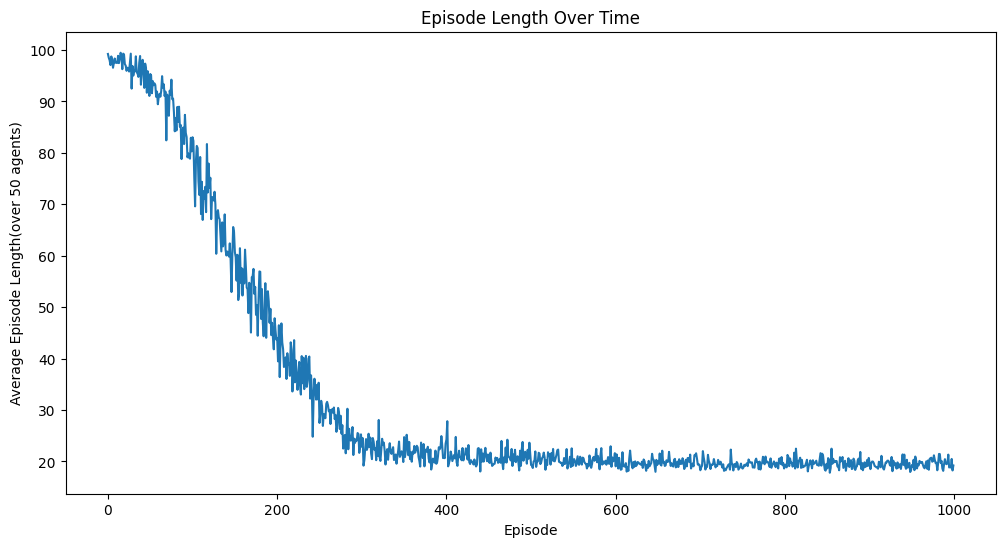

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

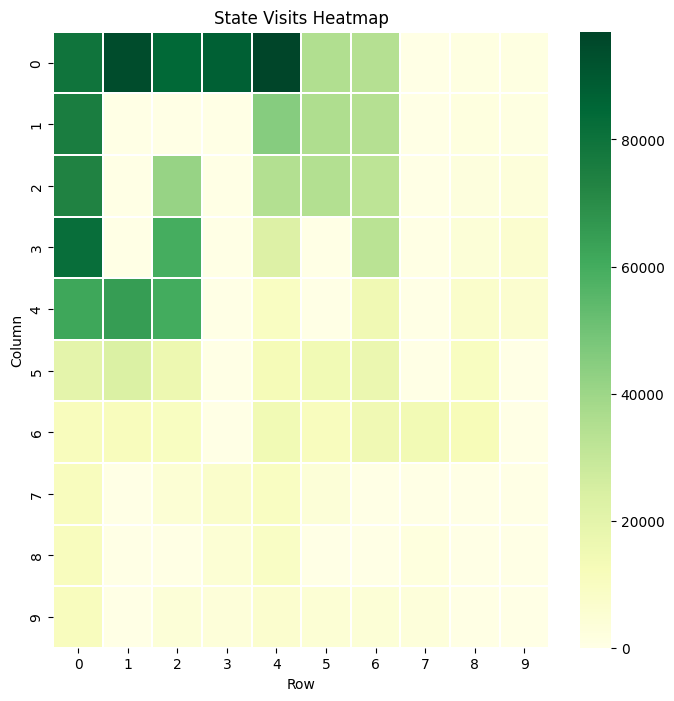

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

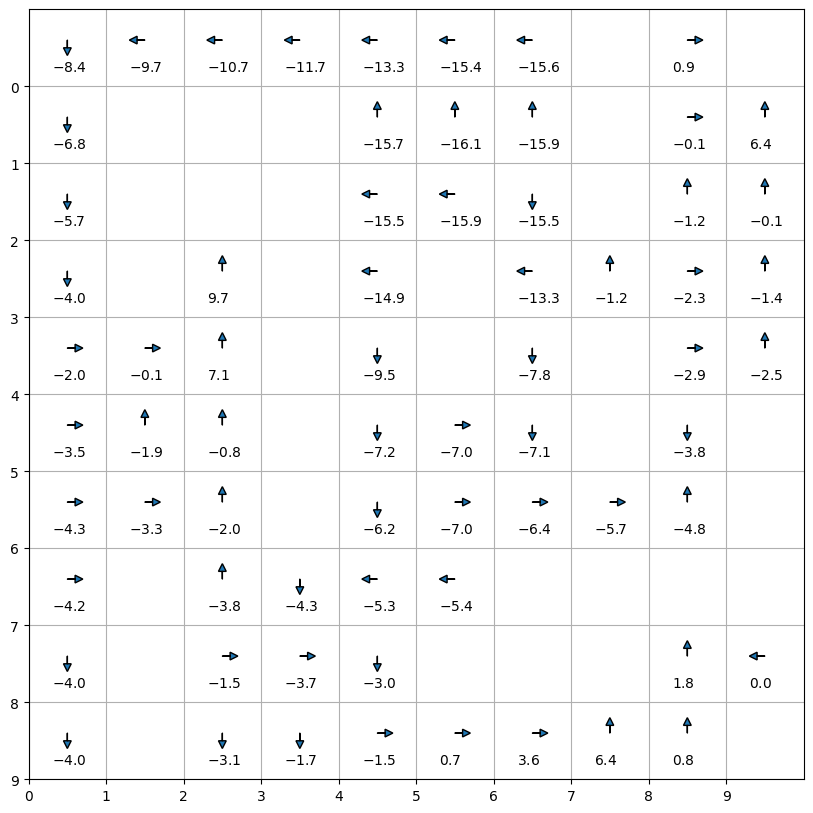

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (0,4) to the goal state at (8,7). The agent passes through a bad state on its way to the goal.
<br>
The policy finds the shortest path to the goal state.
<br>
<br>
The hyperparameters choosen are:
* Gamma [1.0] - The agent values future rewards as much immediate rewards.
* Alpha [0.1] - The agent adjusts slowly to the TD error. This is likely due to the stochasticity of the environment.
* Temperature [0.01] - The agent is condifent in the actions it takes.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:1.0
Alpha:0.1
Epsilon:None
Temperature:0.01


### Effects of the Environment
---

With start state **(0,4)** and wind set to **False** following a **stochastic policy(p=0.7)**;
<br>
Q-Learning agents choose to go to the goal state at (2,2) a majority of the times.
<br>
Due to non-deterministic transition probabilities, the agent takes a longer time to settle on an optimal policy. There is great variation in the rewards per episode. 

# Testing the Config               

## [15] Configuration Parameters
### ID: QLEARNING_S_W-F_S36_E

---
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[3,6]])
wind_ = False
p = 0.7

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_qlearning(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='greedy')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 6821.0742428302765 seconds


In [14]:
# Saving the model
np.save('QLEARNING_S_W-F_S36_E.npy', model)

## Plotting Reward Curves
---

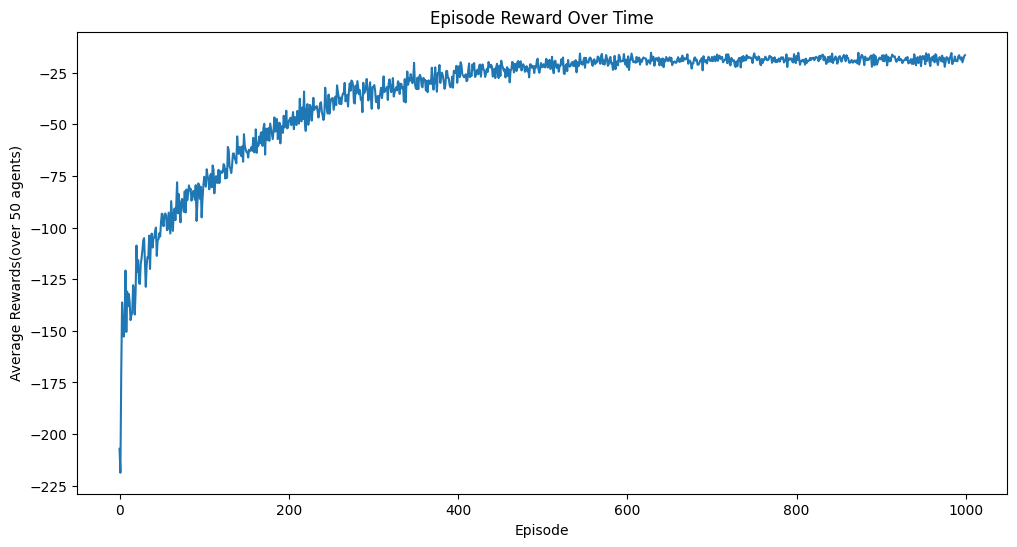

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

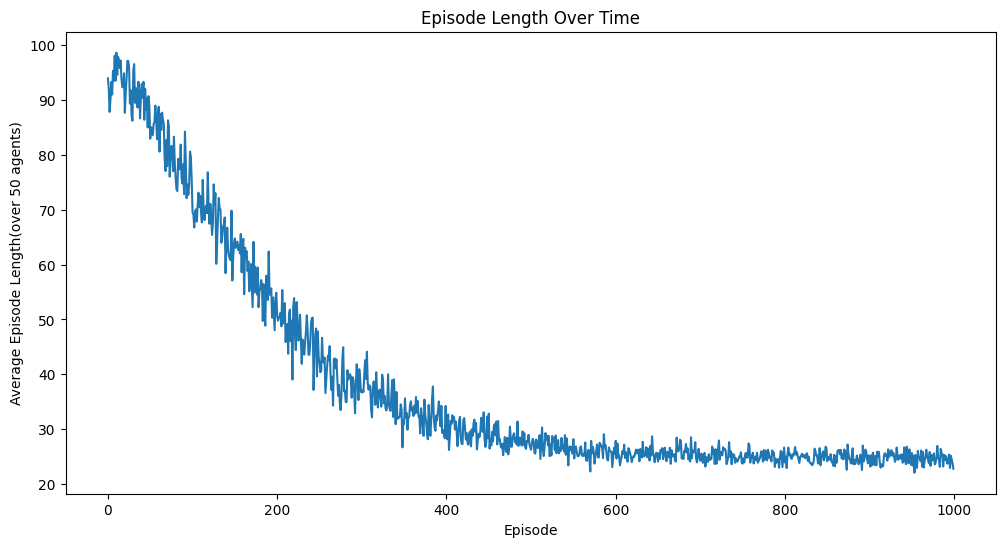

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

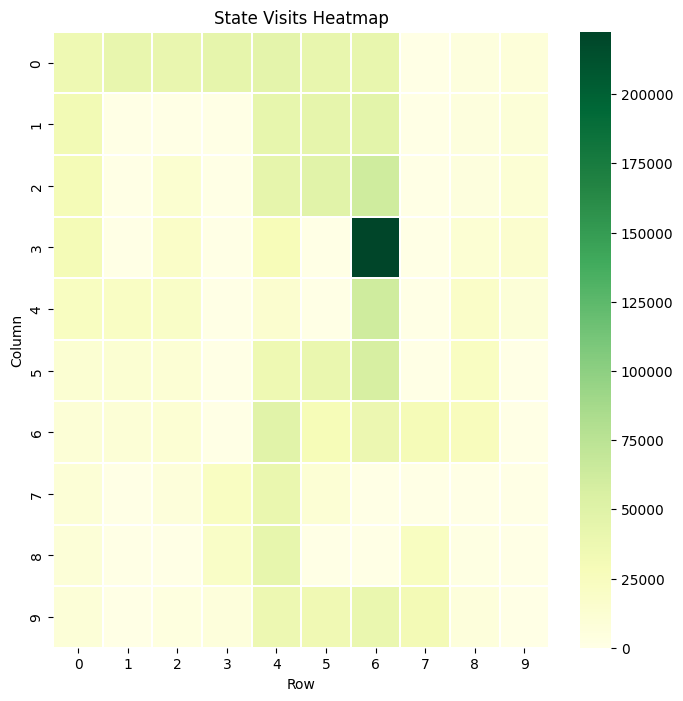

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

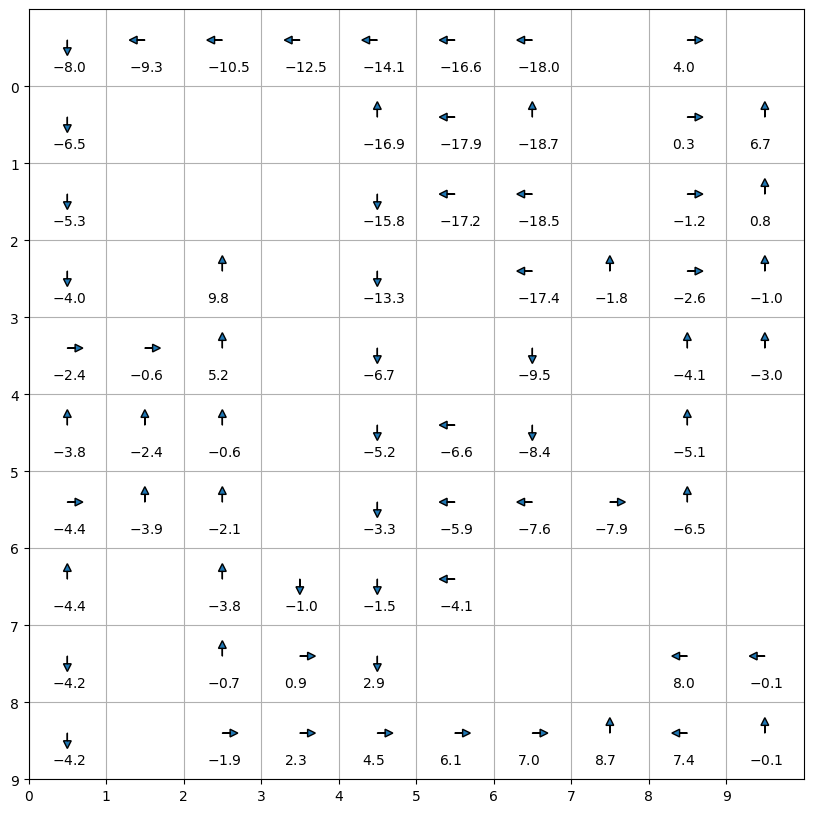

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (3,6) to the goal state at (8,7).
<br>
However, an agent following this policy will get stuck in the start state. This is evident from the high state visit count of the start state(~200000). For comparision other policies visited the start state 50000-80000 times.
The agent might be running into the obstruction or the reset right beside the start state.
<br>
<br>
The hyperparameters choosen are:
* Gamma [1.0] - The agent values future rewards as much immediate rewards.
* Alpha [0.1] - The agent adjusts slowly to the TD error. This is likely due to the stochasticity of the environment.
* Epsilon [0.01] - The agent takes exploratory actions only 1% of the time.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:1.0
Alpha:0.1
Epsilon:0.001
Temperature:None


### Effects of the Environment
---

With start state **(3,6)** and wind set to **False** following a **stochastic policy(p=0.7)**;
<br>
Q-Learning agents choose to go to the goal state at (8,7) a majority of the times. It however struggles to get out of the start state. 
This is due to the start state having an obstruction on one side and a reset on another.
<br>
Due to non-deterministic transition probabilities, the agent takes a longer time to settle on an optimal policy. There is great variation in the rewards per episode.

# Testing the Config               

## [16] Configuration Parameters
### ID: QLEARNING_S_W-F_S36_S

---
Learning algorithm = Q-Learning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = ϵ-greedy

## Instantiating the Environment

---



In [10]:
# specify world parameters

# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# starting position
start_state = np.array([[3,6]])
wind_ = False
p = 0.7

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = wind_)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=p,
                              bias=0.5)
env = gw.create_gridworld()

In [11]:
env.visualize_gridworld()

## Hyperparameters
---

In [12]:
gammas = [0.7, 0.8, 0.9, 1.0]
epsilons = [0.001, 0.01, 0.05, 0.1]
alphas = [0.001, 0.01, 0.1, 1.0]
temperatures = [0.01, 0.1, 1, 2]

## Training
---

In [13]:
start_time = time.time()

model = hyper_search_qlearning(gammas=gammas, epsilons=epsilons, alphas=alphas,temperatures=temperatures, strategy='softmax')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

Time taken: 8999.462862968445 seconds


In [14]:
# Saving the model
np.save('QLEARNING_S_W-F_S36_S.npy', model)

## Plotting Reward Curves
---

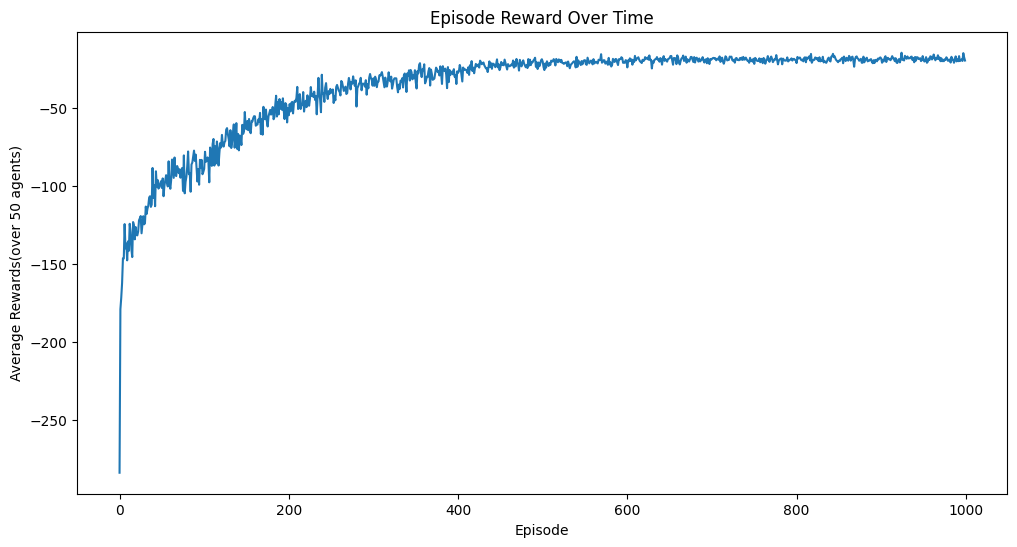

In [15]:
plt.figure(figsize=(12,6))
plt.plot(model['Rewards'])
plt.title('Episode Reward Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Rewards(over 50 agents)')
plt.show()

## Plotting Episode Lengths
---

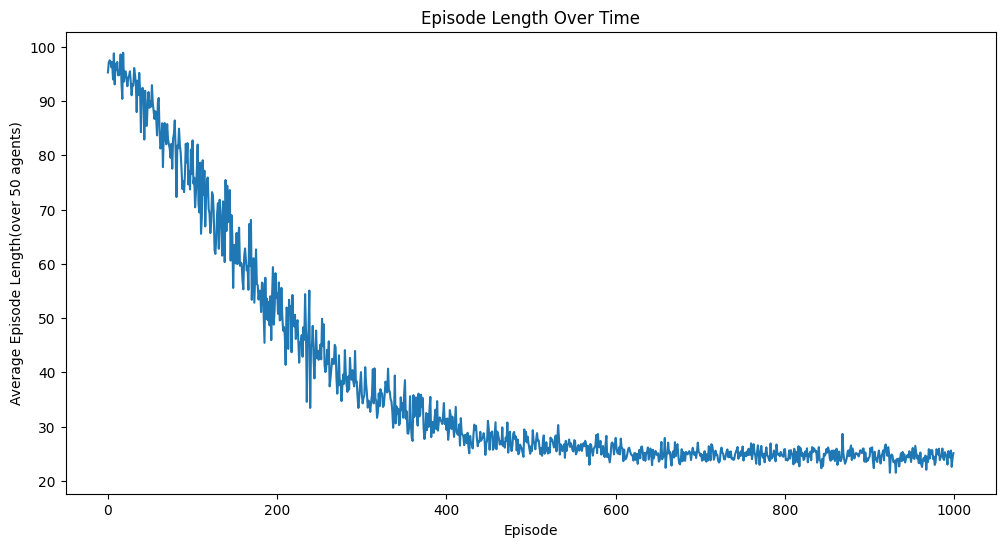

In [16]:
plt.figure(figsize=(12,6))
plt.plot(model['Steps_to_goal'])
plt.title('Episode Length Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Episode Length(over 50 agents)')
plt.show()

## Plotting State-Visit Count Heatmap
---

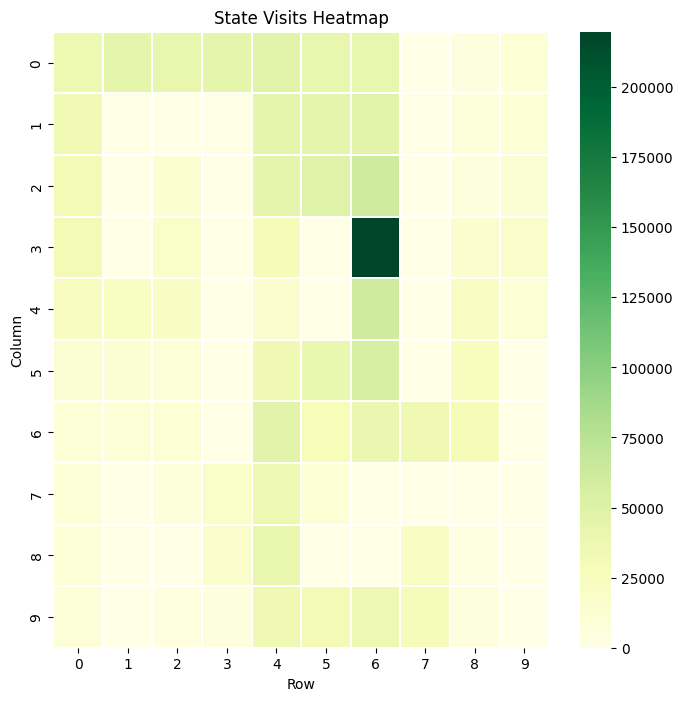

In [17]:
plot_heatmap(model['State_visits'])

## Plotting Optimal Q-values and Optimal Policy
---

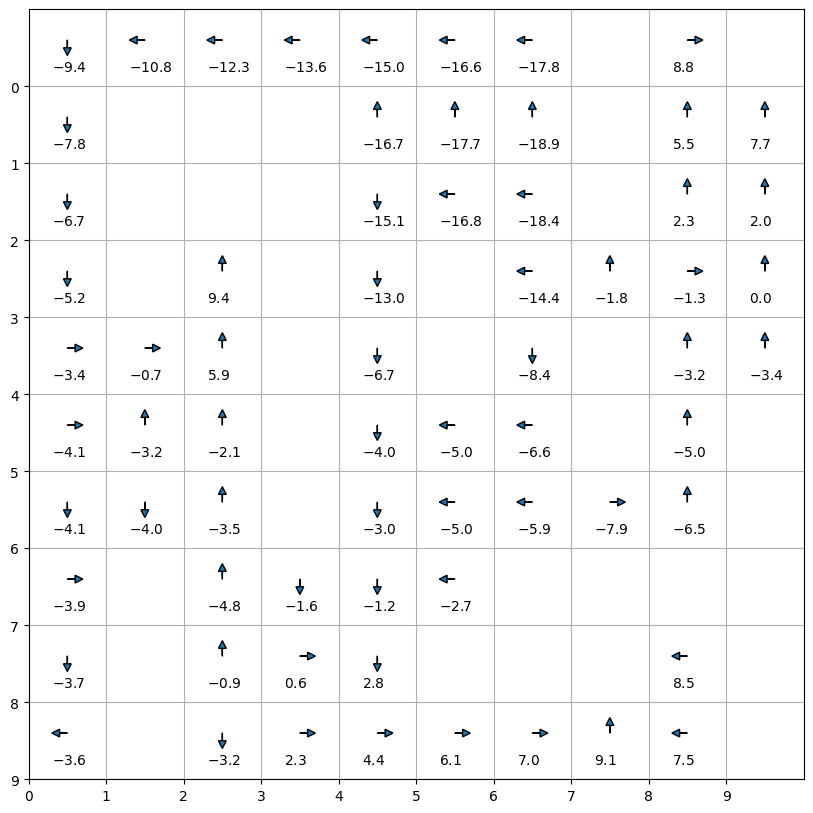

In [18]:
plot_policy(model['Q_values'])

# Analysis

The policy learnt takes the agent from the start state at (3,6) to the goal state at (8,7).
<br>
However, an agent following this policy will get stuck in the start state. This is evident from the high state visit count of the start state(~200000). For comparision other policies visited the start state 50000-80000 times.
The agent might be running into the obstruction or the reset right beside the start state.
<br>
<br>
The hyperparameters choosen are:
* Gamma [1.0] - The agent values future rewards as much immediate rewards.
* Alpha [0.1] - The agent adjusts slowly to the TD error. This is likely due to the stochasticity of the environment.
* Temperature [0.01] - The agent is condifent in the actions it takes.

### Choice of Hyperparameters
---

In [19]:
print('Gamma:'+str(model['Parameters']['gamma']))
print('Alpha:'+str(model['Parameters']['alpha']))
print('Epsilon:'+str(model['Parameters']['epsilon']))
print('Temperature:'+str(model['Parameters']['temperature']))

Gamma:1.0
Alpha:0.1
Epsilon:None
Temperature:0.01


### Effects of the Environment
---

With start state **(3,6)** and wind set to **False** following a **stochastic policy(p=0.7)**;
<br>
Q-Learning agents choose to go to the goal state at (8,7) a majority of the times. It however struggles to get out of the start state. 
This is due to the start state having an obstruction on one side and a reset on another.
<br>
Due to non-deterministic transition probabilities, the agent takes a longer time to settle on an optimal policy. There is great variation in the rewards per episode.